In [1]:
import pandas as pd
import numpy as np

In [2]:
# !pip install pymongo

In [3]:
import pymongo
from pymongo import MongoClient
from pprint import pprint
client = MongoClient(host='localhost',port=27017)

In [4]:
from datetime import datetime
from datetime import timedelta

# Common section

In [5]:
start_time = datetime.strptime('00:00 Jan 01, 2025', '%H:%M %b %d, %Y')
def seconds_to_date_time(seconds):
    return start_time + timedelta(seconds=seconds)

In [6]:
def date_to_day_str(the_date):
    return f'{the_date.year}-{the_date.month}-{the_date.day}'

In [7]:
db = client['vast2020mc1']

In [8]:
db.list_collection_names()

['CGCSGraphDataNodeTypes',
 'DemographicCategories',
 'Q2Seed1',
 'Q1Graph1',
 'Q2Seed3',
 'Q2Seed2',
 'CGCSGraphData',
 'NodeTypeDescriptions',
 'Q1Graph5',
 'Q1Graph3',
 'Q1Graph2',
 'Q1Graph4']

In [14]:
for r in db.CGCSGraphData.find({}).limit(1):
    pprint(r)

{'Source': 639754,
 'SourceLatitude': '',
 'SourceLocation': '',
 'SourceLongitude': '',
 'Target': 643327,
 'TargetLatitude': '',
 'TargetLocation': '',
 'TargetLongitude': '',
 'Time': -132048000,
 'Weight': 0.25,
 '_id': ObjectId('5e95138e7f14623e9133a213'),
 'eType': 4}


In [9]:
def get_time_period(collection):
    time_period = collection.aggregate([{'$group':{'_id': None, 'minTime': { '$min': "$Time" } , 'maxTime': { '$max': "$Time" }}}]).next()
    return time_period

## Time series of eTypes

In [10]:
# Load the type activity
eType_time_series = {}
for r in db.CGCSGraphData.find({}):
    day_str = date_to_day_str(seconds_to_date_time(r['Time']))
    if not day_str in eType_time_series:
        # initialize
        eType_time_series[day_str] = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    eType_time_series[day_str][r['eType']]+=1

In [11]:
#dump these for JS
import json
with open('eType_time_series.json', 'w') as f:
    json.dump(eType_time_series, f)

## node type information (common for all the graphs)
- nodetype2Description gives description of a node type
- node2TypeDescriptiion gives description for a node
- node2Type gives type of a node
- type2Nodes give list of nodes per type
- type2Nodes_counts give the count number of unique nodes in each type
- typeDesc2Nodes_counts give the number of unique nodes in each type description

In [12]:
eTypes = {0: 'Email', 1: 'Phone', 2:'Sell', 3:'Buy', 4: 'Author-of', 5:'Financial (income, expenditure)', 6:'Travels-to'}

In [13]:
nodeType2Description = {}
for r in db.NodeTypeDescriptions.find({}):
    nodeType2Description[r['NodeType']] = r['Description']

In [14]:
node2TypeDescription = {}
for r in db.CGCSGraphDataNodeTypes.find({}):
    node2TypeDescription[r['NodeID']] = nodeType2Description[r['NodeType']]

In [15]:
node2Type = {}
for r in db.CGCSGraphDataNodeTypes.find({}):
    node2Type[r['NodeID']] = r['NodeType']

In [16]:
type2Nodes = {}
for i in range(1, 6):
    type2Nodes[i] = []
for k in node2Type.keys():
    type2Nodes[node2Type[k]].append(k)

In [17]:
type2Nodes_counts = [{"_id": k, "count": len(type2Nodes[k])} for k in type2Nodes.keys()]

In [18]:
type2Nodes_counts

[{'_id': 1, 'count': 164534},
 {'_id': 2, 'count': 2721},
 {'_id': 3, 'count': 33622},
 {'_id': 4, 'count': 29},
 {'_id': 5, 'count': 6}]

In [41]:
typeDesc2Nodes_counts = [{"_id": nodeType2Description[item["_id"]] , "count": item["count"]} for item in type2Nodes_counts]

In [42]:
typeDesc2Nodes_counts

[{'_id': 'Person', 'count': 164534},
 {'_id': 'Product category', 'count': 2721},
 {'_id': 'Document', 'count': 33622},
 {'_id': 'Financial category', 'count': 29},
 {'_id': 'Country', 'count': 6}]

# Node counts for the big graph

In [ ]:
# countings
# source_counts = list(db.CGCSGraphData.aggregate([{"$group": {"_id": "$Source", "count": {"$sum": 1}}}, {"$sort": {"count":-1}}]))
# target_counts = list(db.CGCSGraphData.aggregate([{"$group": {"_id": "$Target", "count": {"$sum": 1}}}, {"$sort": {"count":-1}}]))
# eType_counts = list(db.CGCSGraphData.aggregate([{"$group": {"_id": "$eType", "count": {"$sum": 1}}}, {"$sort": {"count":-1}}]))
# # save
# import pickle
# with open('source_counts.pkl', 'wb') as f:
#     pickle.dump(source_counts, f)
# with open('target_counts.pkl', 'wb') as f:
#     pickle.dump(target_counts, f)
# with open('eType_counts.pkl', 'wb') as f:
#     pickle.dump(eType_counts, f)

In [ ]:
# load
import pickle
with open('source_counts.pkl', 'rb') as f:
    source_counts = pickle.load(f)
with open('target_counts.pkl', 'rb') as f:
    target_counts = pickle.load(f)
with open('eType_counts.pkl', 'rb') as f:
    eType_counts = pickle.load(f)

In [ ]:
time_period = get_time_period(db.CGCSGraphData)
minTime = seconds_to_date_time(time_period['minTime'])
maxTime = seconds_to_date_time(time_period['maxTime'])

## eType counts

In [105]:
def get_graph_statistics(source_counts, target_counts, eType_counts):
    # eTypes counts, count number of edges with a specific eTypeDescription counts
    eTypeDesc_counts = [{'_id': eTypes[item["_id"]], 'count': item['count']} for item in eType_counts]
    
    # node counts: count appearances of a node
    node_counts = {}
    for r in db.CGCSGraphDataNodeTypes.find({}):
        node_counts[r['NodeID']] = 0
    # add count from source
    for item in source_counts:
        node_counts[item["_id"]] += item["count"]
    # add count from target
    for item in target_counts:
        node_counts[item["_id"]] += item["count"]

    node_counts = [{"_id": key, 'count': node_counts[key]} for key in node_counts.keys() if node_counts[key]!=0] # convert to standard list
    node_counts.sort(key=lambda x: x['count'], reverse=True)
    
    # Source node type count and source node type description count
    source_nodeType_counts = {}
    for i in range(1, 6):
        source_nodeType_counts[i] = 0
    for item in source_counts:
        source = item["_id"]
        nodeType = node2Type[source]
        source_nodeType_counts[nodeType] += item["count"]
    source_nodeType_counts = [{"_id": key, "count": source_nodeType_counts[key]} for key in source_nodeType_counts.keys()]
    source_nodeTypeDesc_counts = [{"_id": nodeType2Description[item["_id"]], 'count': item['count']} for item in source_nodeType_counts]
    source_nodeTypeDesc_counts
    
    # Target node type count and source node type description count
    target_nodeType_counts = {}
    for i in range(1, 6):
        target_nodeType_counts[i] = 0
    for item in target_counts:
        target = item["_id"]
        nodeType = node2Type[target]
        target_nodeType_counts[nodeType] += item["count"]
    target_nodeType_counts = [{"_id": key, "count": target_nodeType_counts[key]} for key in target_nodeType_counts.keys()]
    target_nodeTypeDesc_counts = [{"_id": nodeType2Description[item["_id"]], 'count': item['count']} for item in target_nodeType_counts]
    target_nodeTypeDesc_counts
    
    # source and target (both) node type and node type description counts
    nodeType_counts = [{"_id": source_nodeType_counts[i]["_id"], 'count': source_nodeType_counts[i]['count'] + target_nodeType_counts[i]['count']} for i in range(5)]
    nodeTypeDesc_counts = [{"_id": nodeType2Description[item["_id"]], 'count': item['count']} for item in nodeType_counts]
    
    return eTypeDesc_counts, node_counts, source_nodeType_counts, source_nodeTypeDesc_counts, target_nodeType_counts, target_nodeTypeDesc_counts, nodeType_counts, nodeTypeDesc_counts

In [83]:
def print_counts(counts, title):
    print(title)
    for item in counts:
        print(f'{item["_id"]:40}{item["count"]:>15,}')

In [117]:
from matplotlib import cm

In [118]:
a = {"one": 1, "two": 2}

In [119]:
for i, k in enumerate(a):
    print(i, k)

0 one
1 two


2

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import describe
from matplotlib.lines import Line2D
import networkx as nx
def plot_top_field_counts(field_counts, n_items, title=None, xlabel=None, ylabel=None, type_map = None):
    plt.figure(figsize=(20, 10))
    
    x_vals = [str(x["_id"]) + "-" + str(type_map[x["_id"]]) if type_map is not None else str(x["_id"]) for x in field_counts[0:n_items]]
    y_vals = [x['count'] for x in field_counts[:n_items]]
    viridis = cm.get_cmap('viridis', len(type_map.keys()))
    color_map = {}
    for i, k in enumerate(type_map):
        color_map[type_map[k]] = viridis.colors[i]
        
    colors = [color_map[str(type_map[x["_id"]])] if type_map is not None else str(x["_id"]) for x in field_counts[0:n_items]]
    plt.bar(x_vals, y_vals, color=colors)
    
    plt.xlabel(xlabel, fontdict={'size': 20})
    plt.ylabel(ylabel, fontdict={'size': 20})
    plt.title(title, fontdict={'size': 24})
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.rc('ytick', labelsize=12)
    plt.rc('xtick', labelsize=12)
    plt.rc('xlabel')
    
    #Legends
#     custom_lines = [Line2D([0], [0], color=color_map[type_map[k]], lw=4) for k in type_map.keys()]

#     ax.legend(custom_lines, [type_map[k] for k in type_map.keys()])
    
    plt.grid(b=True, axis='y')
    _ = plt.xticks(rotation=-90)


def plot_degree_distribution(counts, title):
    plt.figure(figsize=(20, 10))
    plt.plot((sorted([item["count"] for item in counts])))
    plt.title(title)
    plt.xlabel('Node (order number)', fontdict={'size': 20})
    plt.ylabel('Degree', fontdict={'size': 20})
    plt.title(title, fontdict={'size': 24})
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.rc('ytick', labelsize=12)
    plt.rc('xtick', labelsize=12)
    plt.grid(b=True, axis='y')

In [25]:
def graph_statistics_from_counts(source_counts, target_counts, eType_counts):
    eTypeDesc_counts, node_counts, source_nodeType_counts, source_nodeTypeDesc_counts, target_nodeType_counts, target_nodeTypeDesc_counts, nodeType_counts, nodeTypeDesc_counts = get_graph_statistics(source_counts, target_counts, eType_counts)
    print("="*100)
    print_counts(eTypeDesc_counts, "Unique eType description counts")
    print("="*100)
    print_counts(typeDesc2Nodes_counts, "Number of unique nodes (do not consider duplications) per node type description")
    print("="*100)
    print_counts(source_nodeTypeDesc_counts, "Number of source nodes (do count duplications) per node type description")
    print("="*100)
    print_counts(target_nodeTypeDesc_counts, "Number of target nodes (do count duplications) per node type description")
    print("="*100)
    print_counts(nodeTypeDesc_counts, "Number of nodes (both node source and target, and count duplications) per node type descripition")

    plot_top_field_counts(eType_counts, 30, 'eType counts', 'eType', 'count', eTypes)
    plot_top_field_counts(type2Nodes_counts, 30, 'Unique node type counts', 'node type', 'count', nodeType2Description)
    plot_top_field_counts(source_counts, 30, f'Source counts (of {len(source_counts)} unique source nodes)', 'source', 'count', node2TypeDescription)
    plot_top_field_counts(target_counts, 30, 'Target counts', 'target', 'count', node2TypeDescription)
    plot_top_field_counts(node_counts, 30, 'Node counts', 'node', 'count', node2TypeDescription)

    plot_degree_distribution(source_counts, 'outdegree distribution')
    plot_degree_distribution(target_counts, 'indegree distribution')
    plot_degree_distribution(node_counts, 'degree distribution')

Unique eType description counts
Phone                                        70,661,593
Email                                        48,662,103
Financial (income, expenditure)               2,041,841
Travels-to                                    1,491,998
Sell                                            389,211
Buy                                             389,211
Author-of                                       259,304
Number of unique nodes (do not consider duplications) per node type description
Person                                          164,534
Product category                                  2,721
Document                                         33,622
Financial category                                   29
Country                                               6
Number of source nodes (do count duplications) per node type description
Person                                      123,709,026
Product category                                      0
Document                       

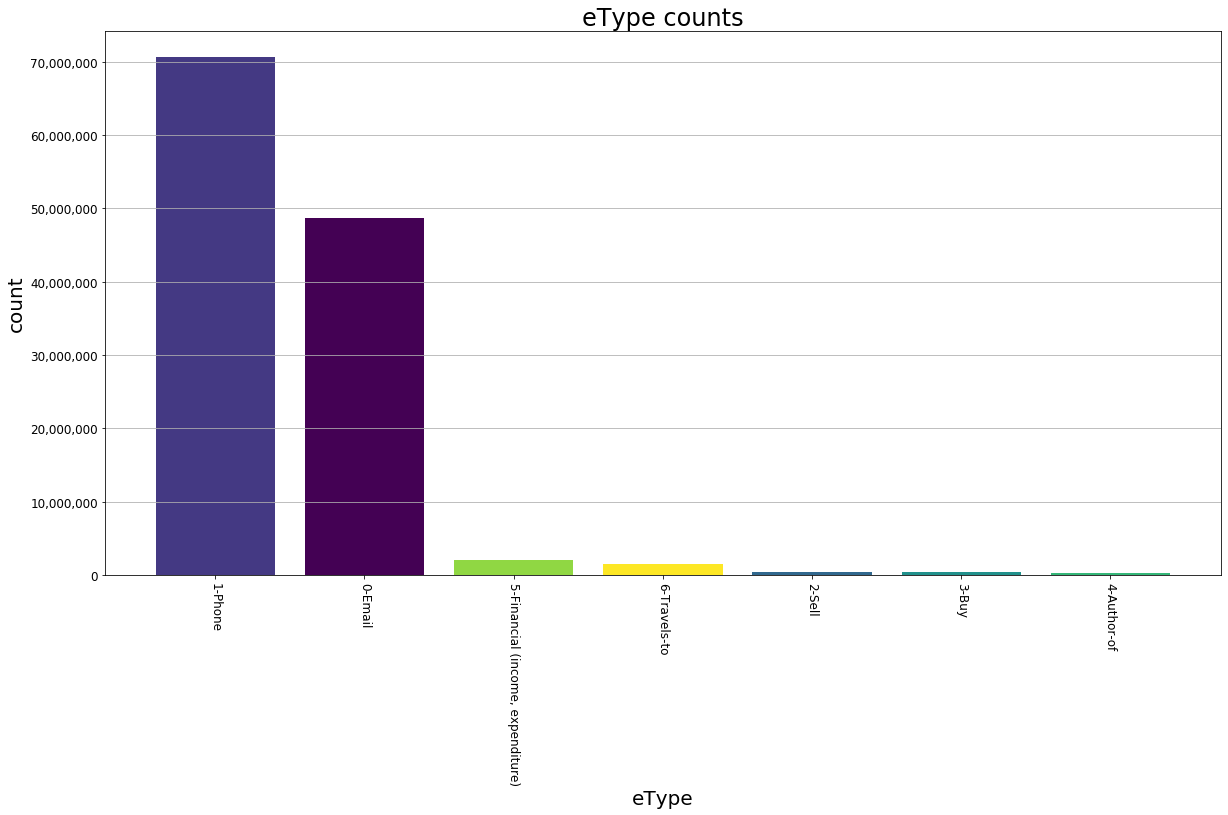

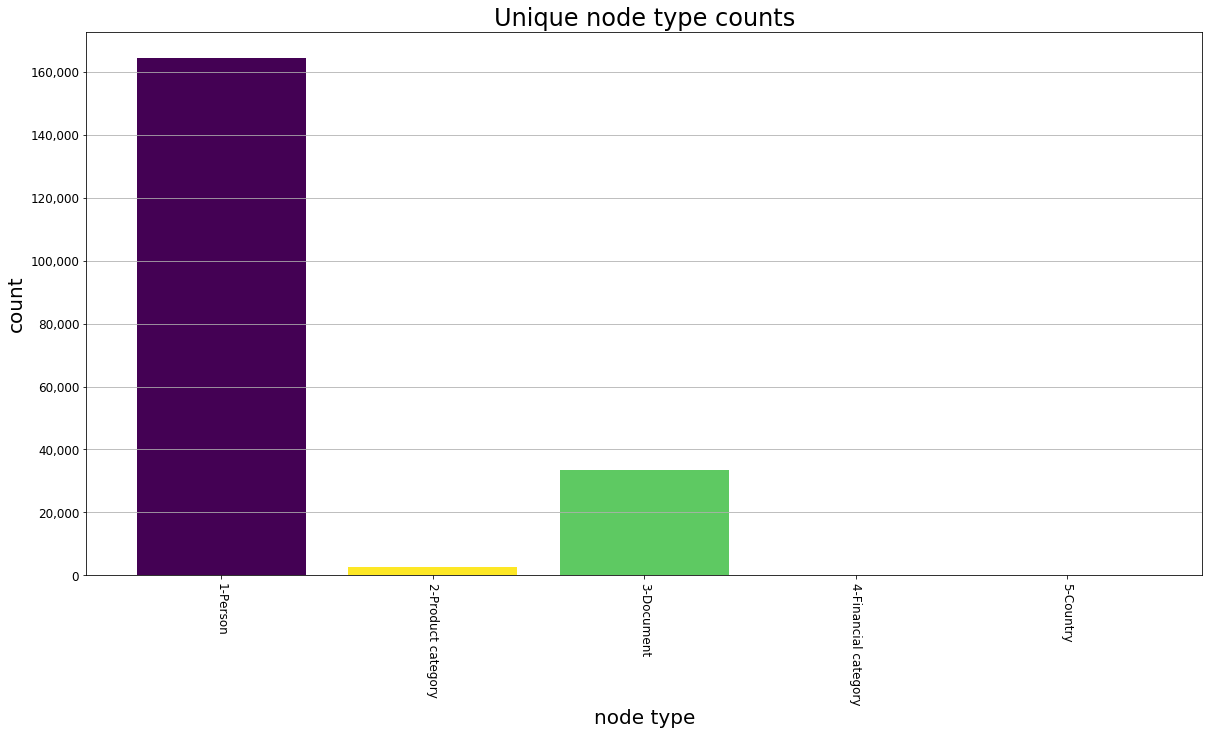

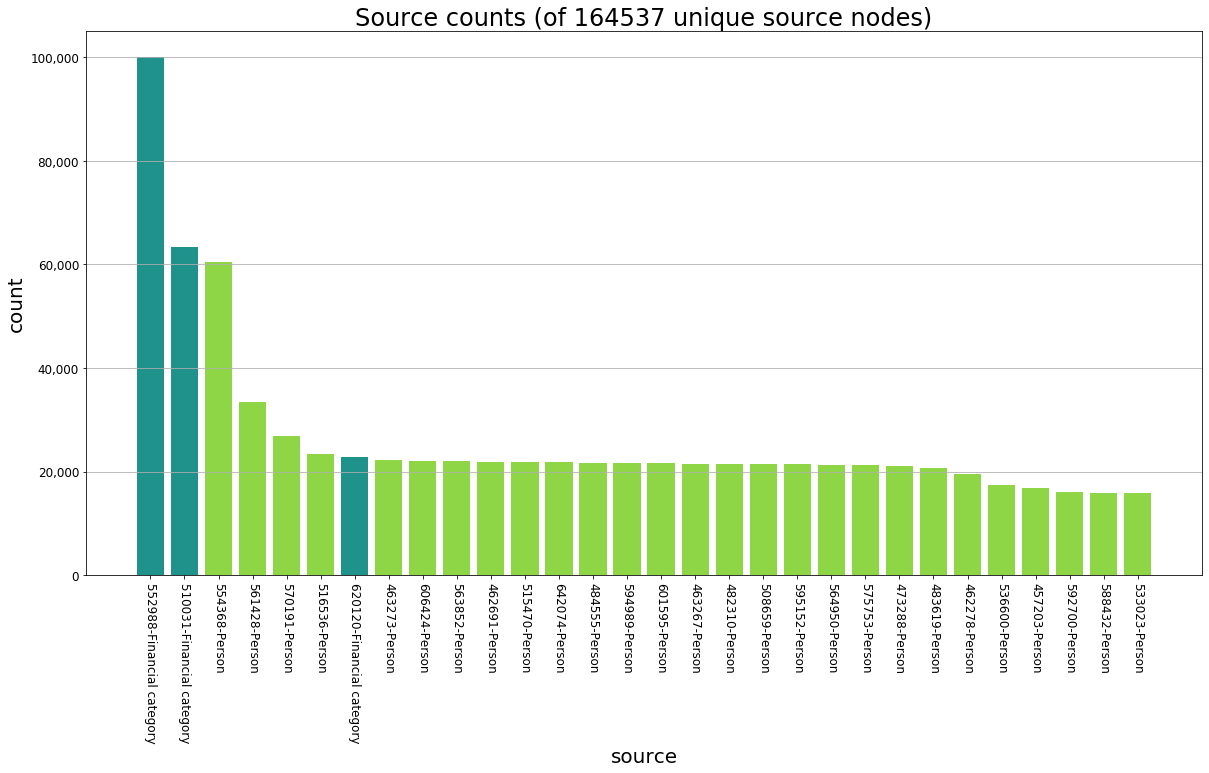

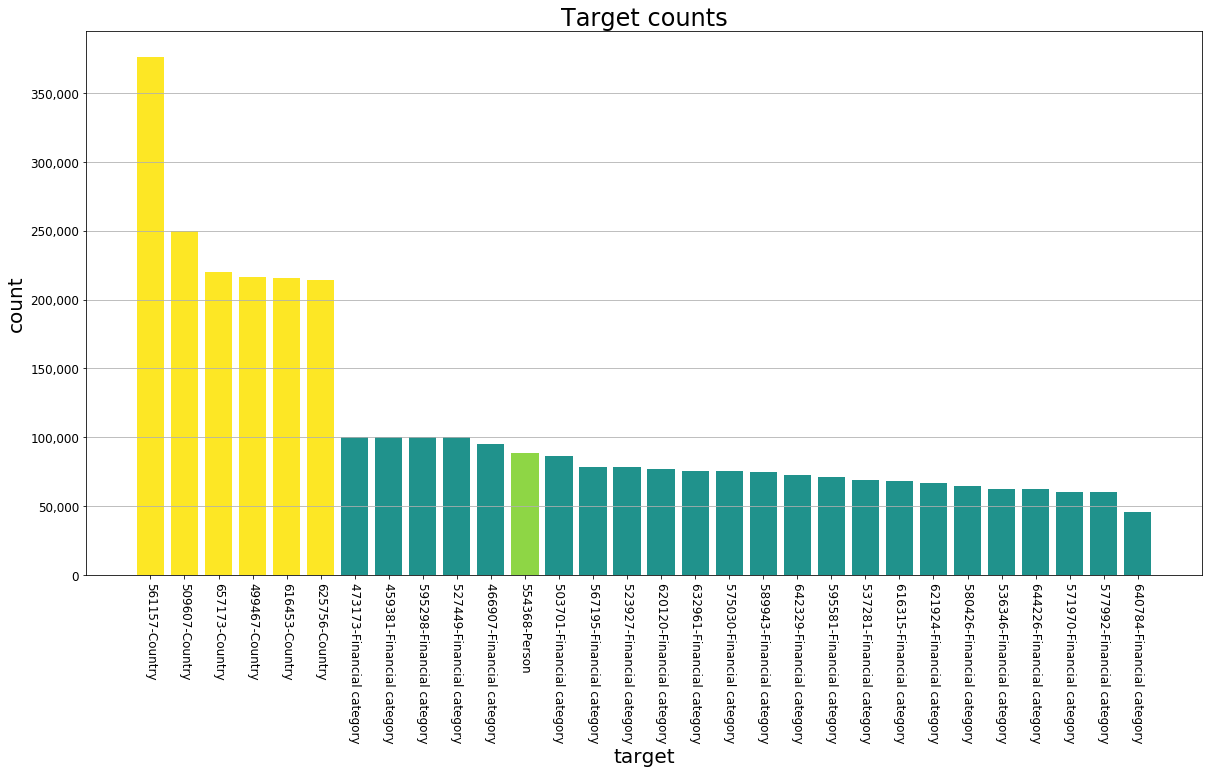

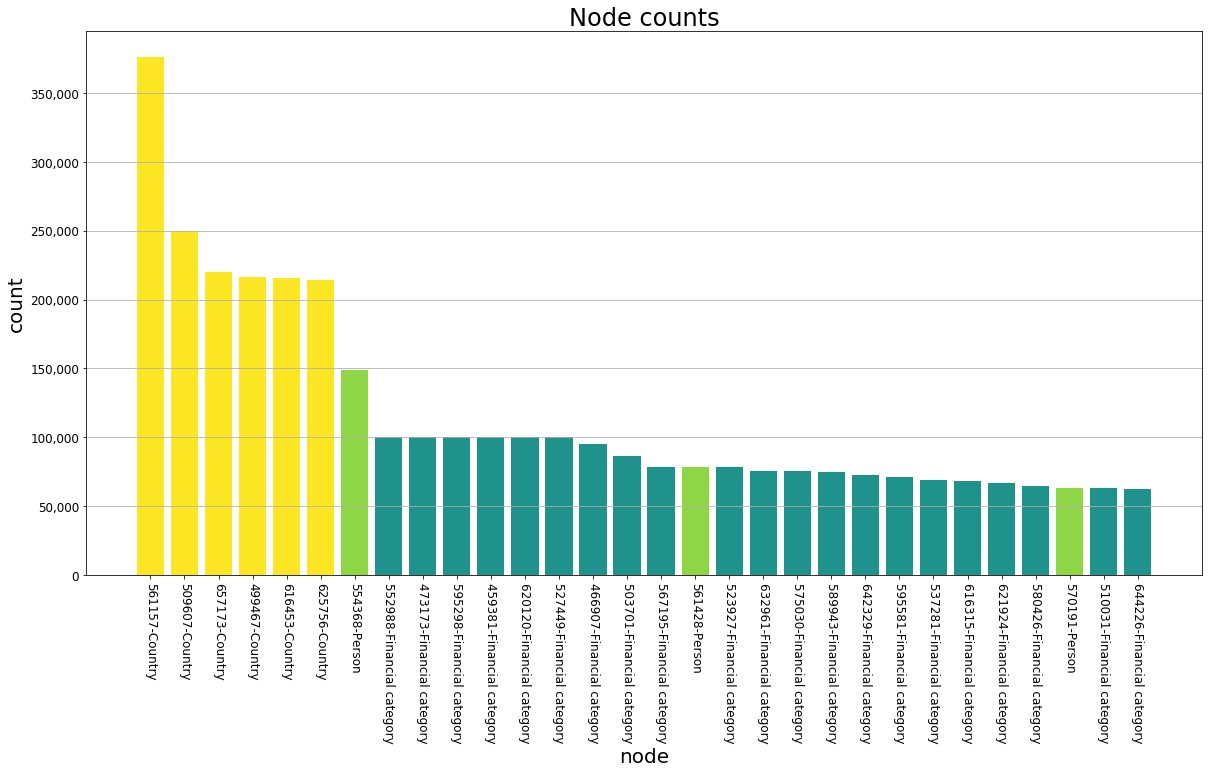

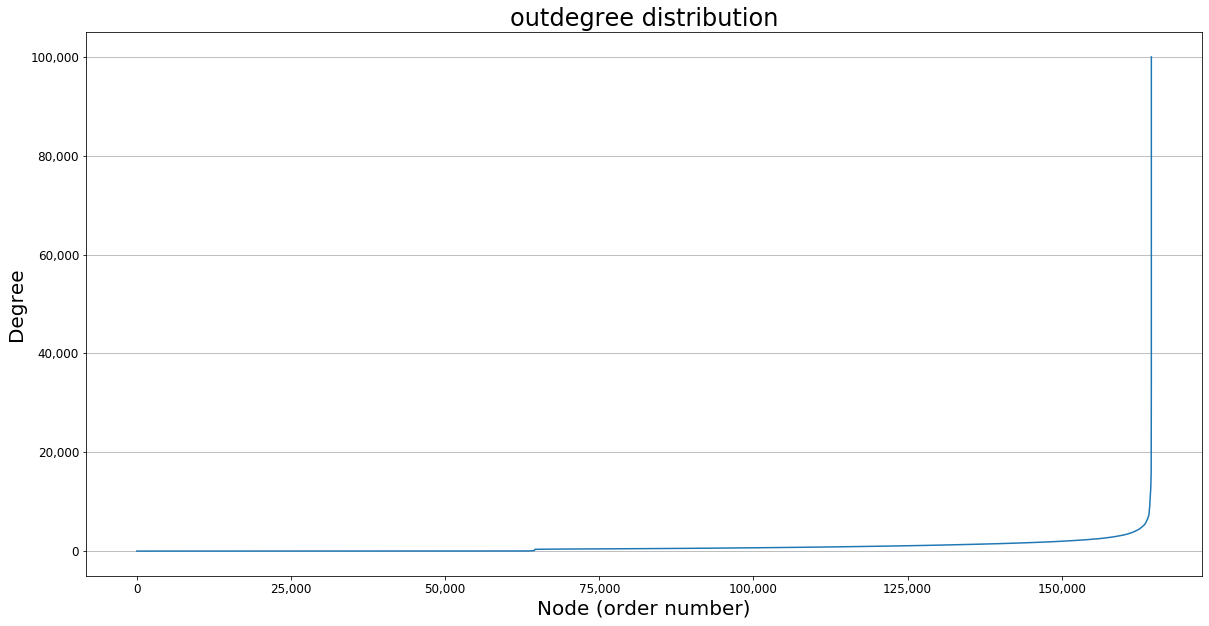

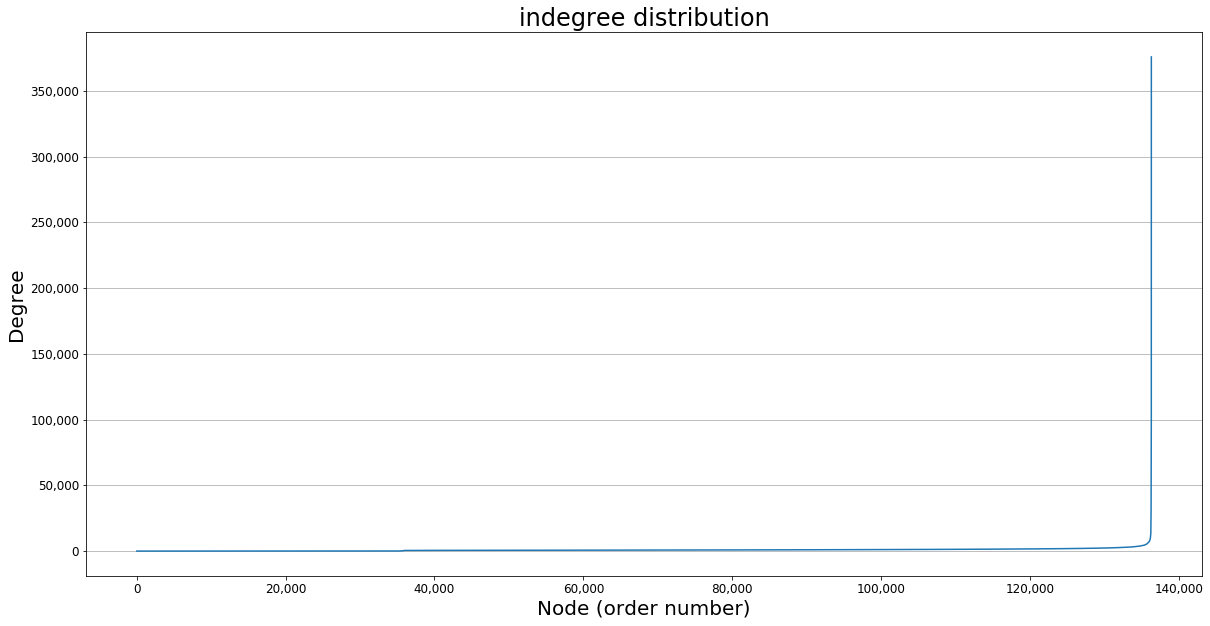

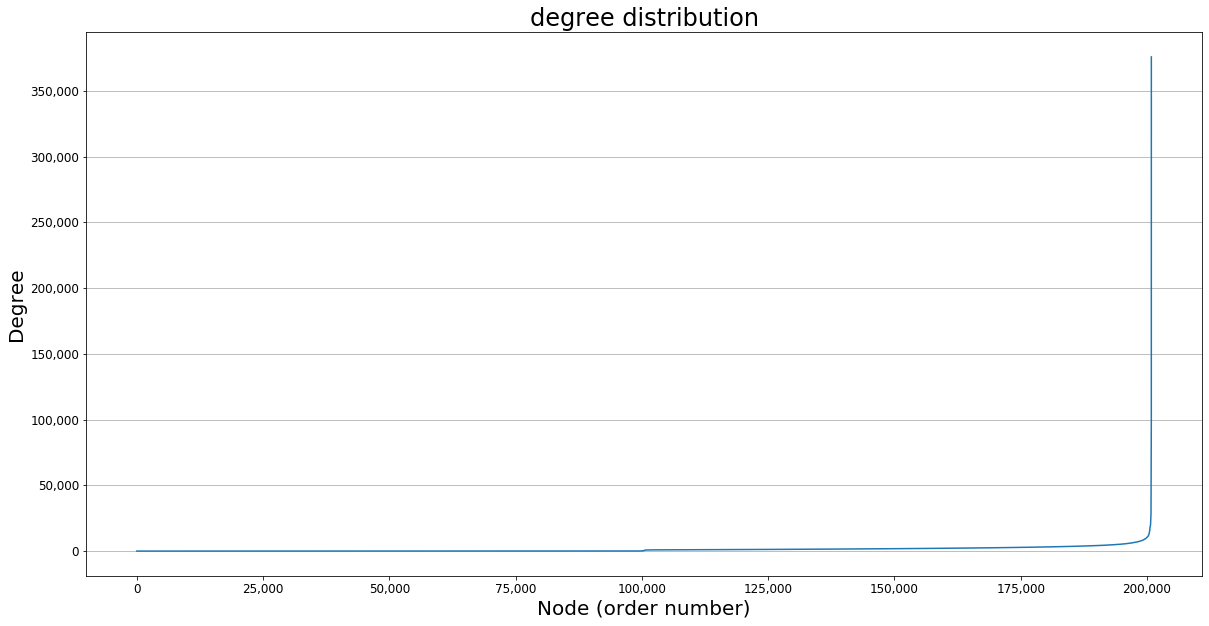

In [156]:
graph_statistics_from_counts(source_counts, target_counts, eType_counts)

# Template graphs

In [81]:
def get_time_period(collection):
    time_period = collection.aggregate([{'$group':{'_id': None, 'minTime': { '$min': "$Time" } , 'maxTime': { '$max': "$Time" }}}]).next()
    return time_period

In [97]:
def print_time_period(collection):
    time_period = get_time_period(collection)
    minTime = seconds_to_date_time(time_period['minTime'])
    maxTime = seconds_to_date_time(time_period['maxTime'])
    print(minTime)
    print(maxTime)

In [94]:
def do_counts(collection):
    target_counts = list(collection.aggregate([{"$group": {"_id": "$Target", "count": {"$sum": 1}}}, {"$sort": {"count":-1}}]))
    source_counts = list(collection.aggregate([{"$group": {"_id": "$Source", "count": {"$sum": 1}}}, {"$sort": {"count":-1}}]))
    eType_counts = list(collection.aggregate([{"$group": {"_id": "$eType", "count": {"$sum": 1}}}, {"$sort": {"count":-1}}]))
    return target_counts, source_counts, eType_counts

In [20]:
from matplotlib.lines import Line2D
def plot_graph(collection):
    cursor = collection.find({})
    df =  pd.DataFrame(list(cursor))
    cmap = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    G = nx.MultiDiGraph()
    for i in range(len(df)):
        G.add_edge(df.loc[i]['Source'], df.loc[i]['Target'], color=cmap[df.loc[i]['eType']])
    pos = nx.spring_layout(G, seed=1, k = 20, iterations=1000)
    # pos = nx.circular_layout(G)
    edges = G.edges(data=True)
    colors = [d['color'] for u,v,d in edges]
    plt.figure(figsize=(20, 10))
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color=colors, alpha=0.3)
    nodes = nx.draw_networkx_nodes(G, pos, node_color='blue')
    
    
    ax = plt.gca()
    custom_lines = [Line2D([0], [0], color=c, lw=4) for c in cmap]
    ax.legend(custom_lines, list(eTypes.values()))

In [313]:
def analyze_graph_from_collection(collection):
    print("="*100)
    print_time_period(collection)
    plot_graph(collection)
    target_counts, source_counts, eType_counts = do_counts(collection)
    graph_statistics_from_counts(target_counts, source_counts, eType_counts)

2004-01-09 11:39:07
2026-01-01 00:00:00


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Unique eType description counts
Financial (income, expenditure)                     846
Email                                               187
Phone                                               131
Travels-to                                           37
Buy                                                   7
Sell                                                  7
Author-of                                             1
Number of unique nodes (do not consider duplications) per node type description
Person                                          164,534
Product category                                  2,721
Document                                         33,622
Financial category                                   29
Country                                               6
Number of source nodes (do count duplications) per node type description
Person                                              400
Product category                                     14
Document                       

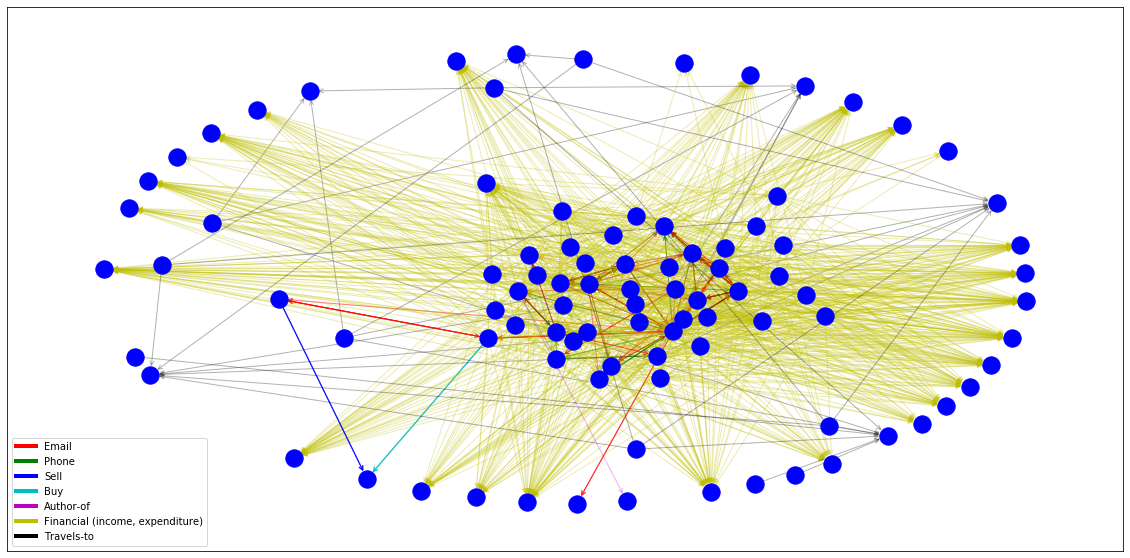

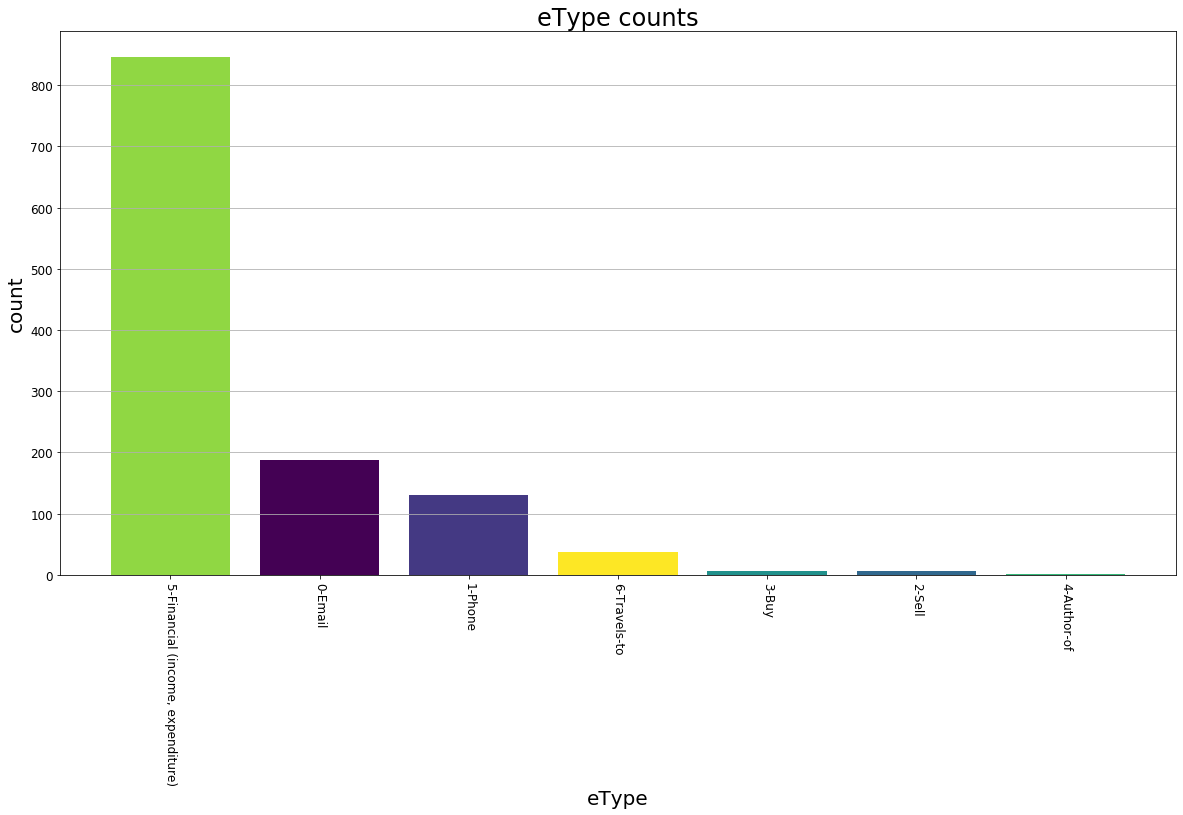

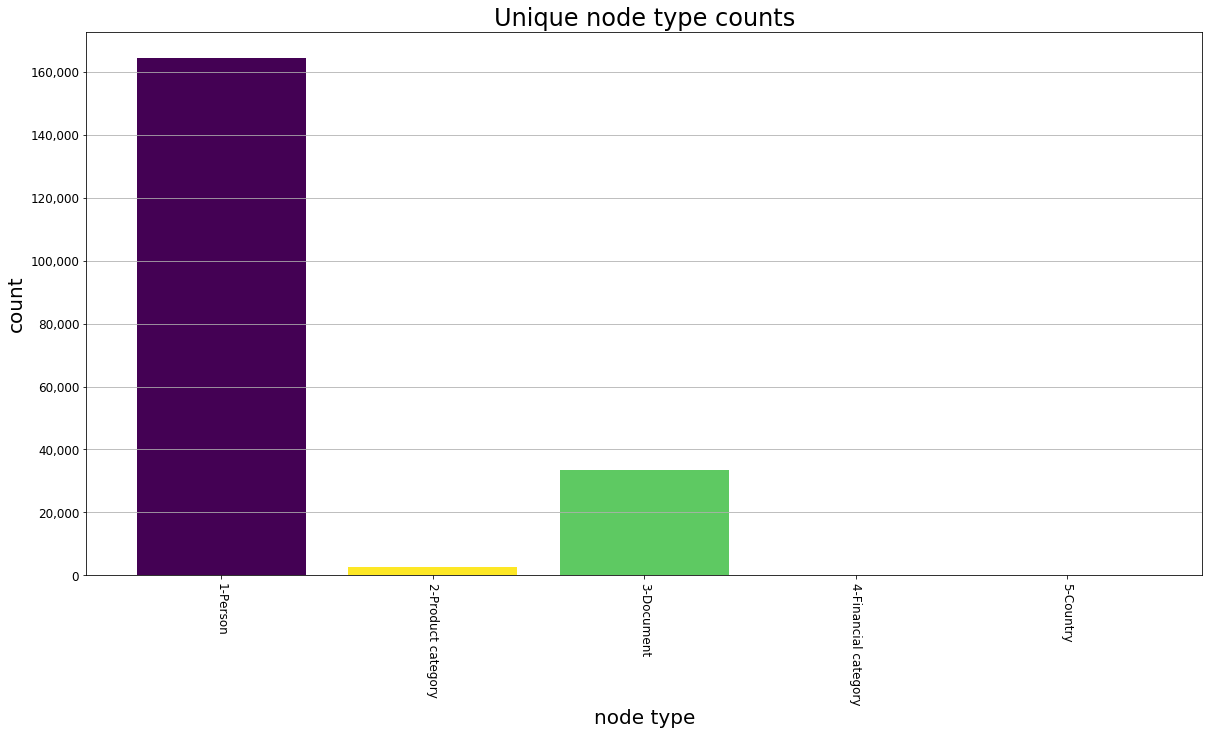

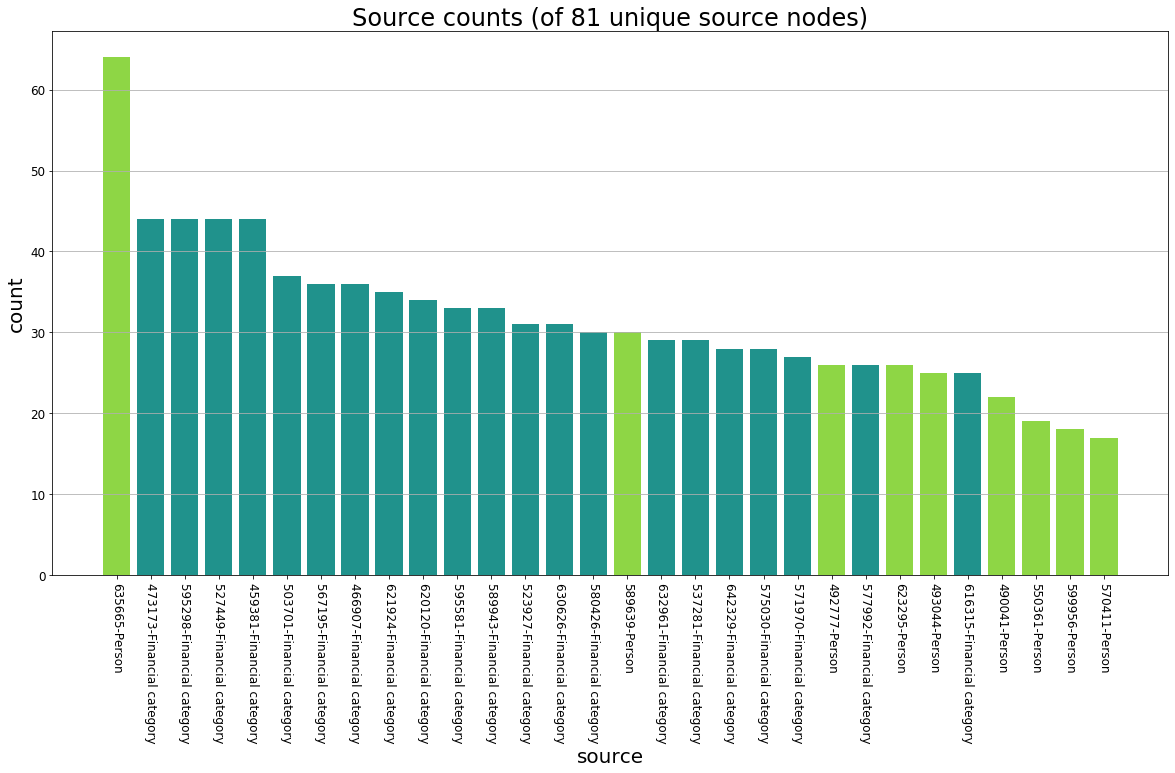

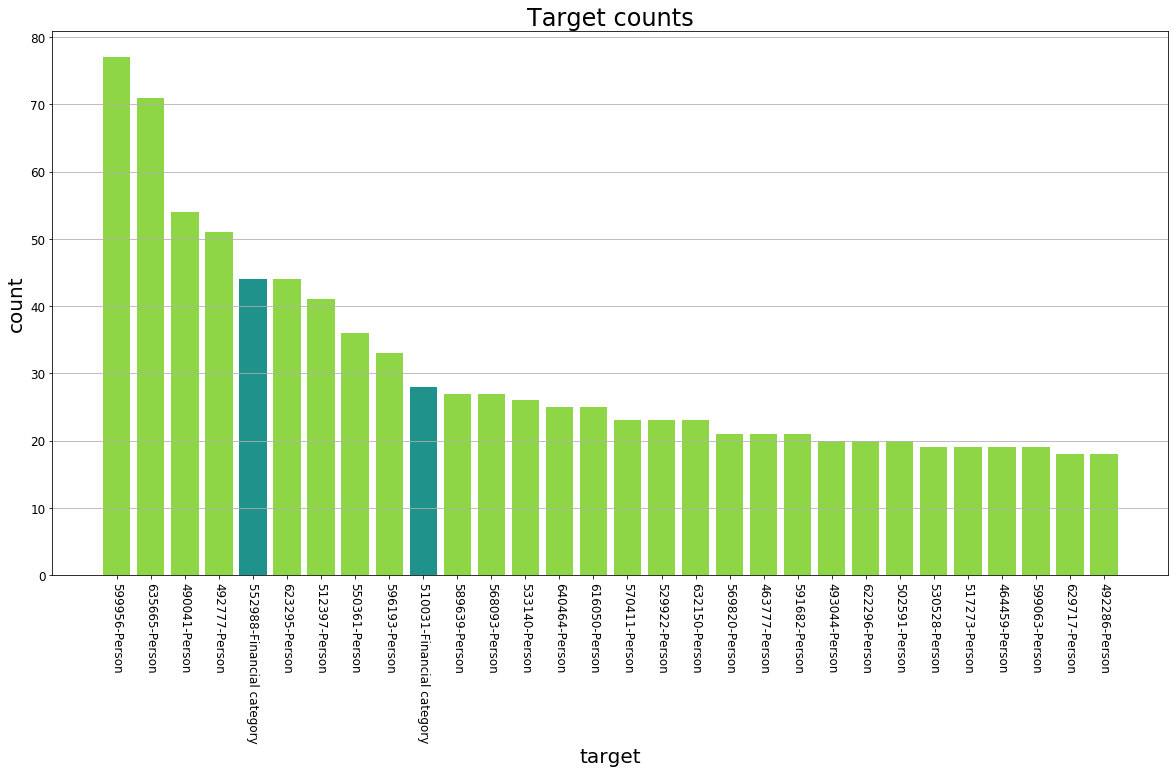

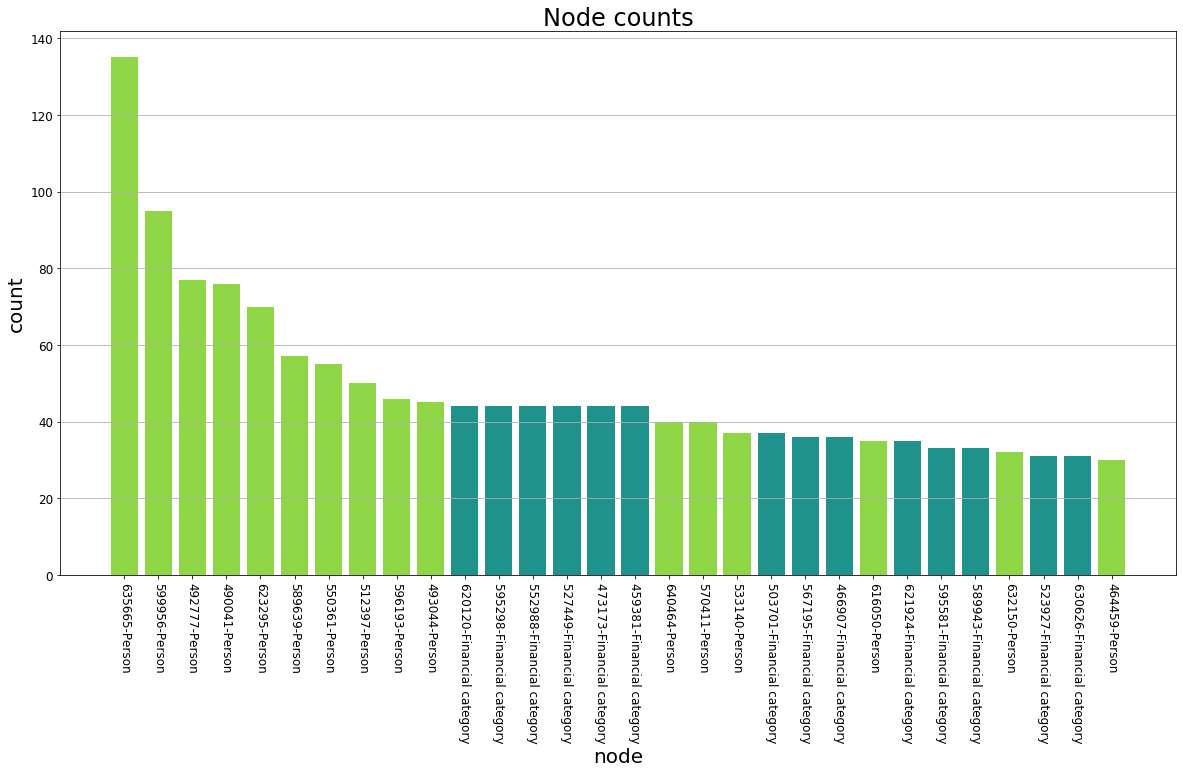

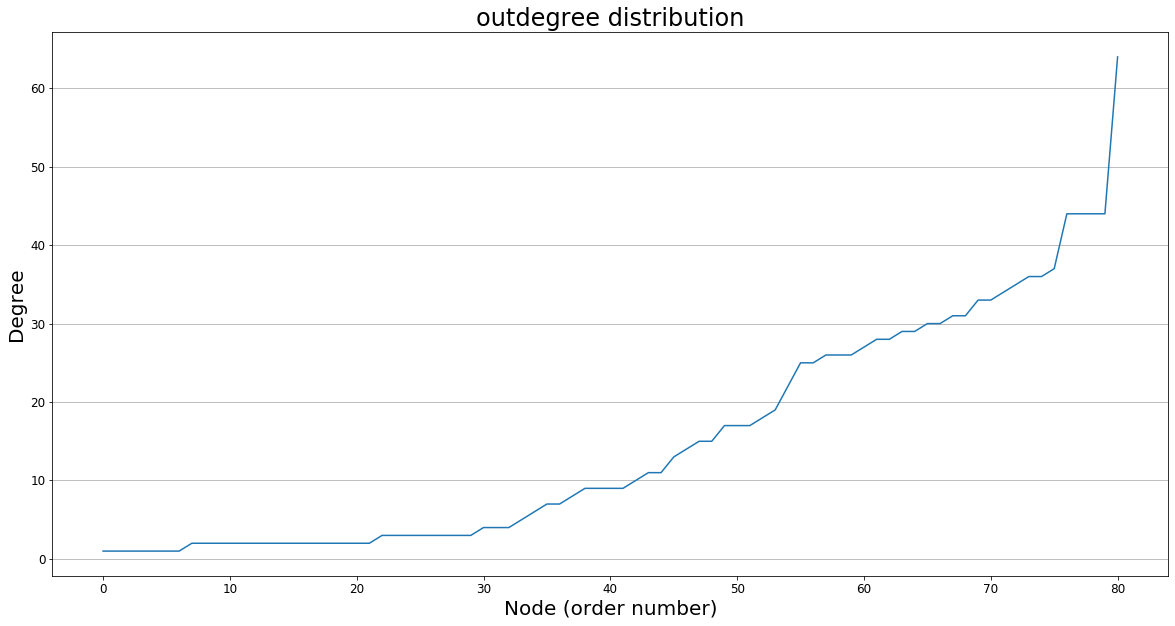

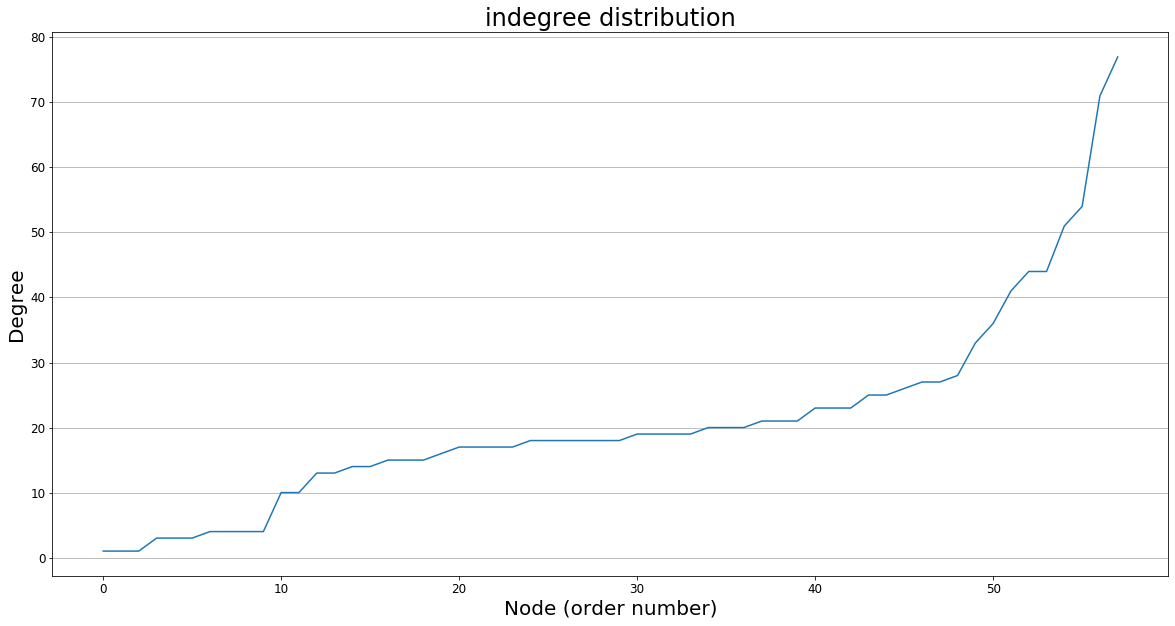

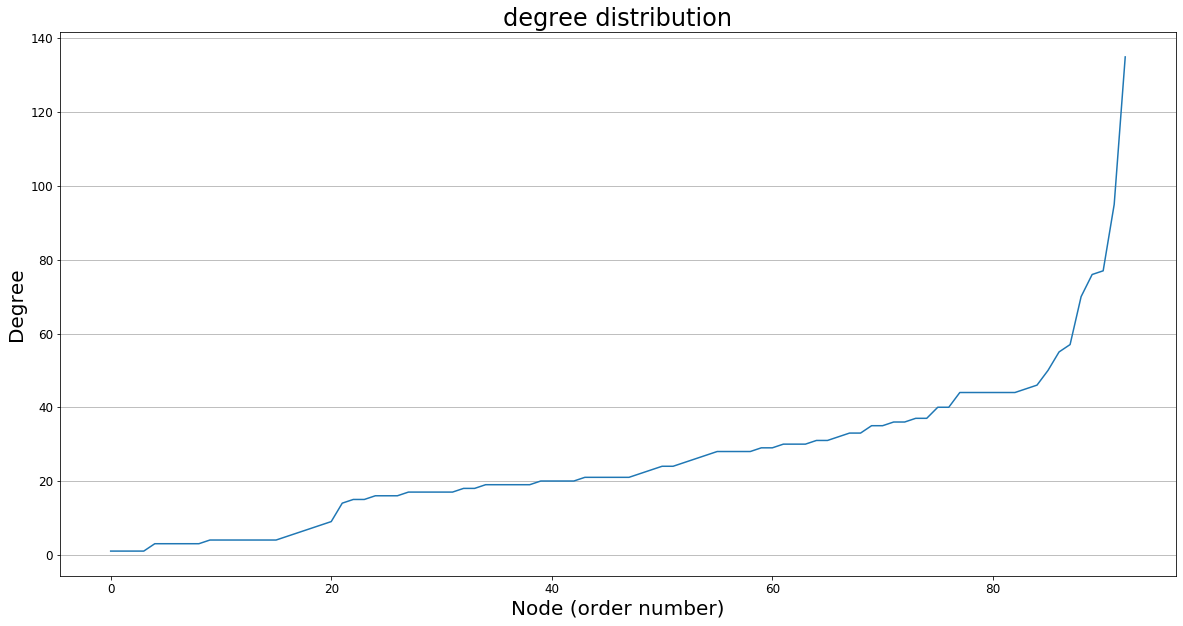

In [314]:
analyze_graph_from_collection(db.Q1Graph1)

2001-10-13 08:27:54
2026-01-01 00:00:00
Unique eType description counts
Financial (income, expenditure)                     823
Email                                               258
Phone                                               177
Travels-to                                           24
Sell                                                  7
Buy                                                   7
Author-of                                             4
Number of unique nodes (do not consider duplications) per node type description
Person                                          164,534
Product category                                  2,721
Document                                         33,622
Financial category                                   29
Country                                               6
Number of source nodes (do count duplications) per node type description
Person                                              506
Product category                               

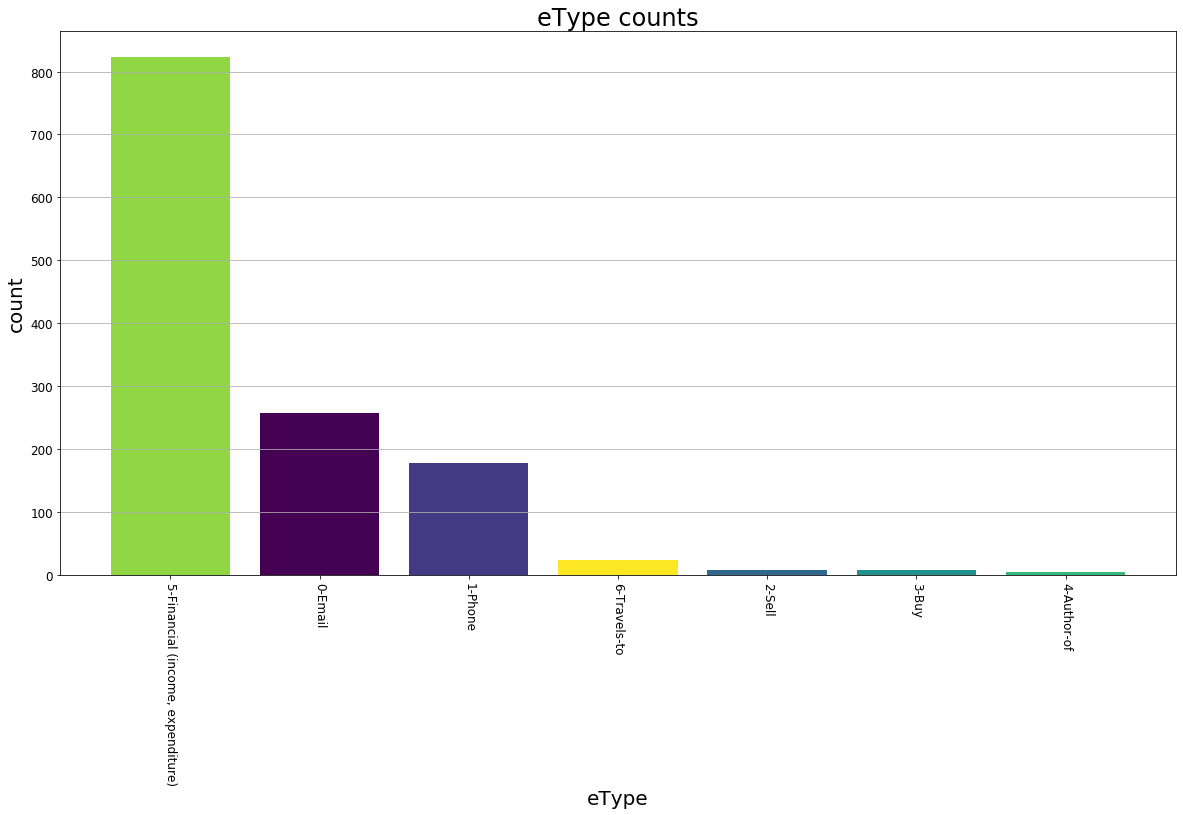

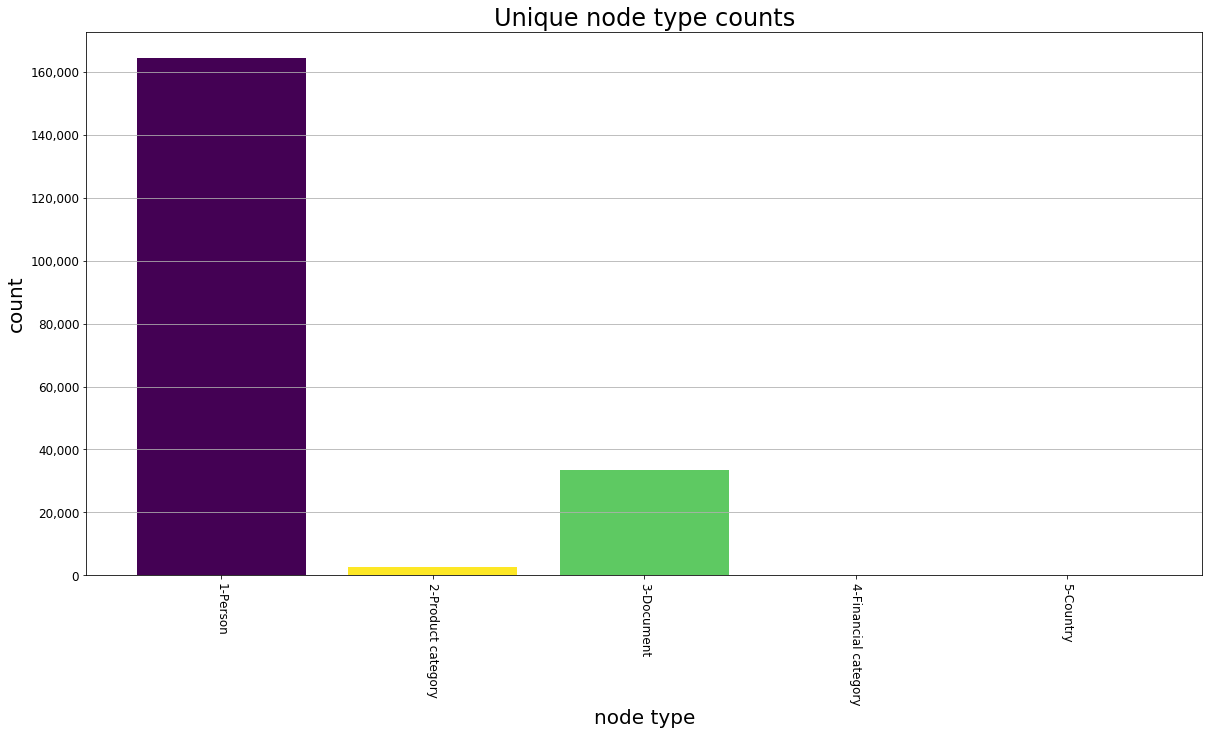

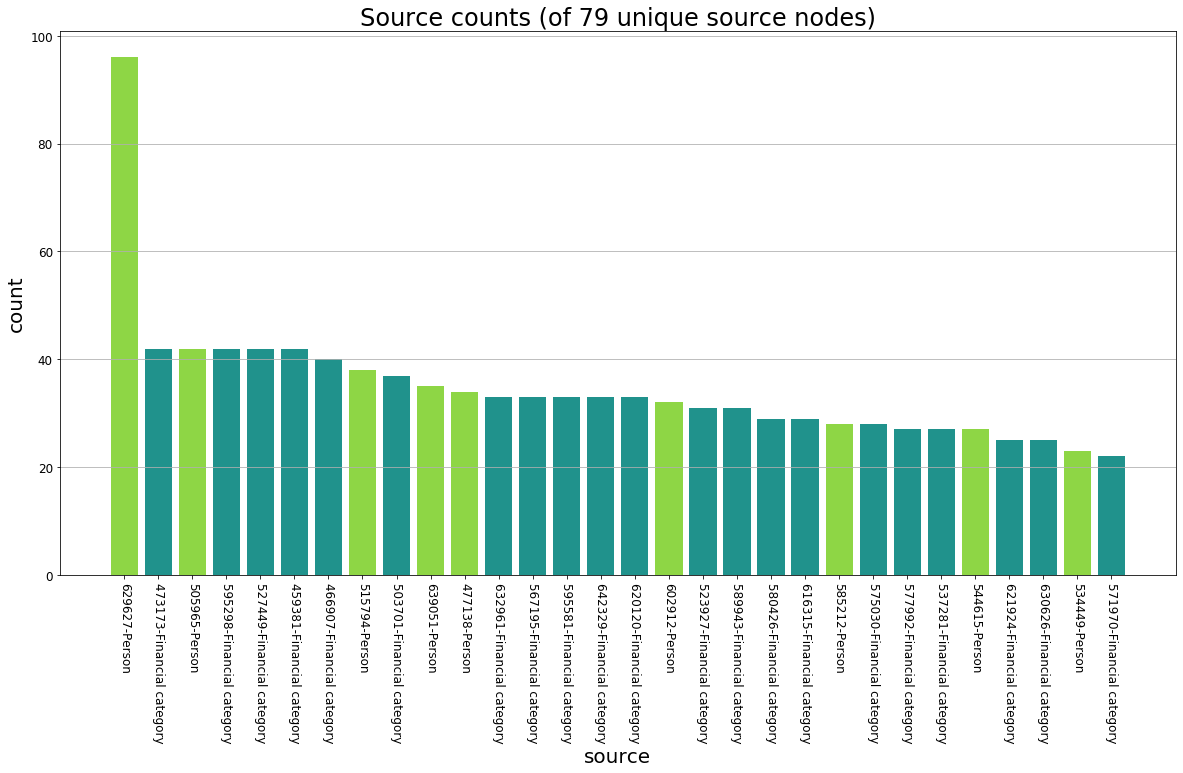

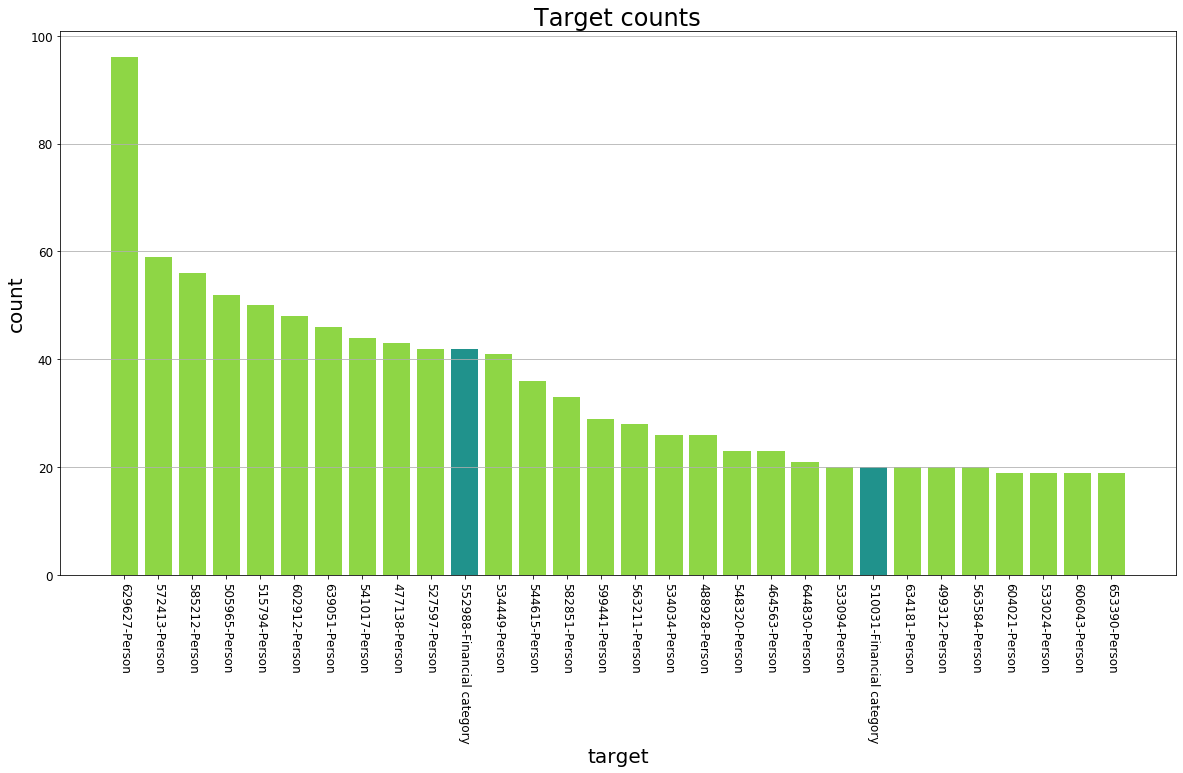

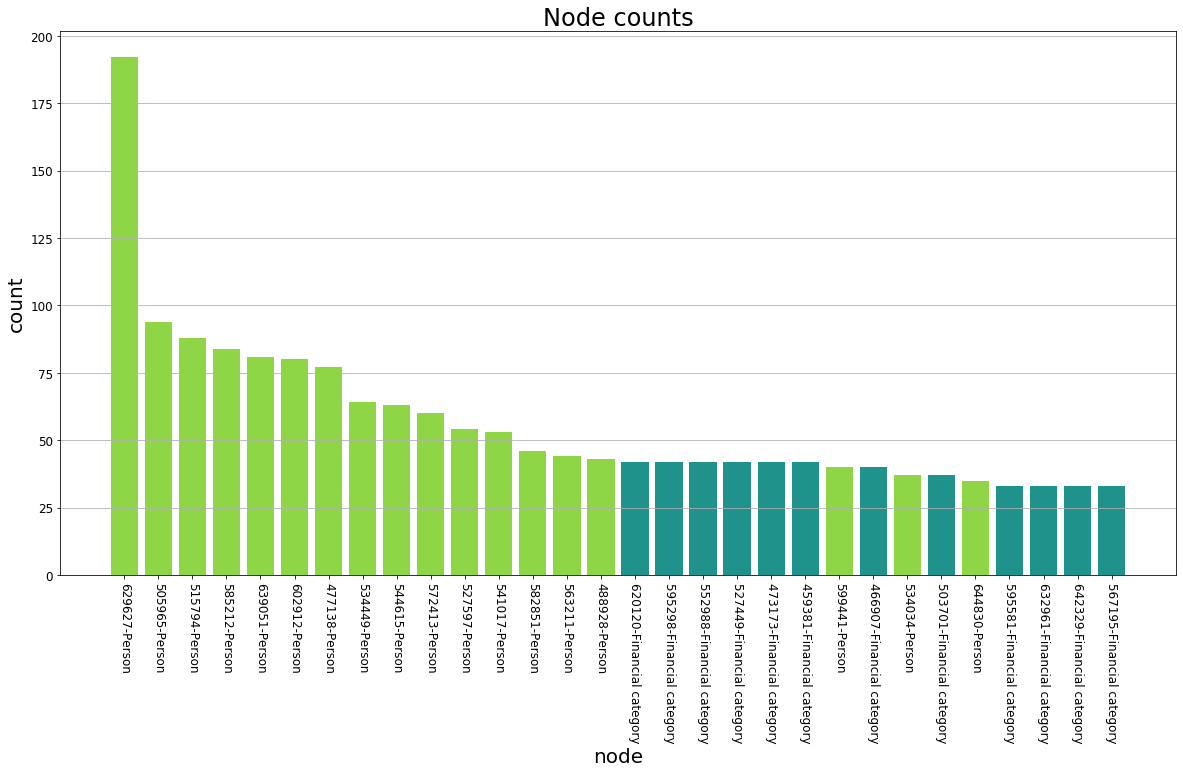

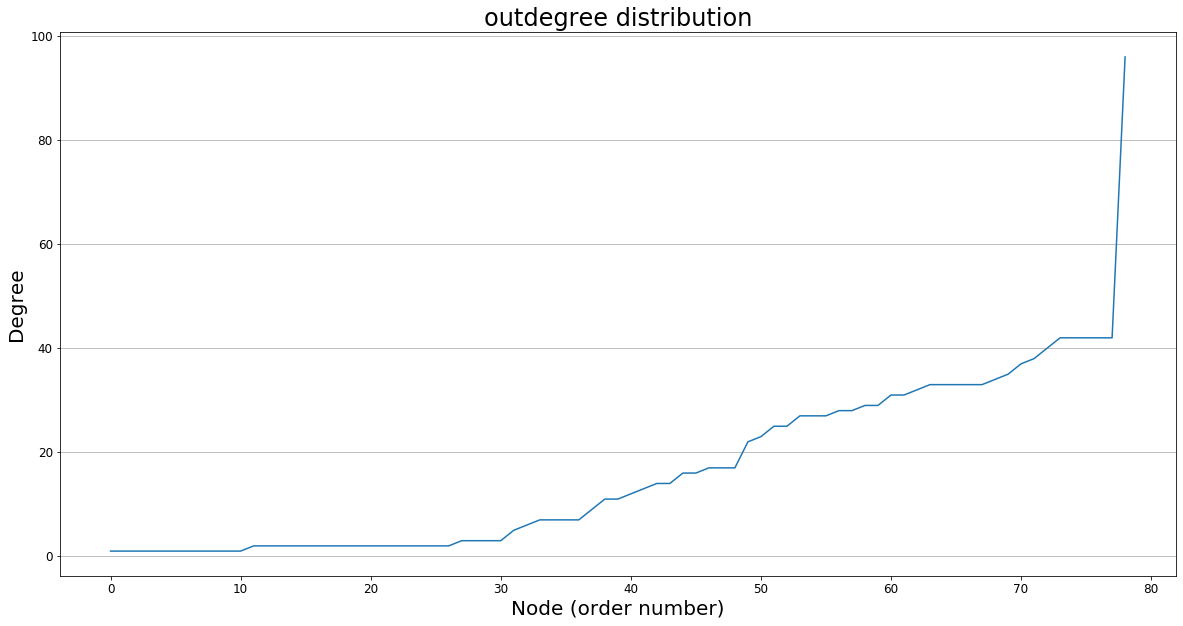

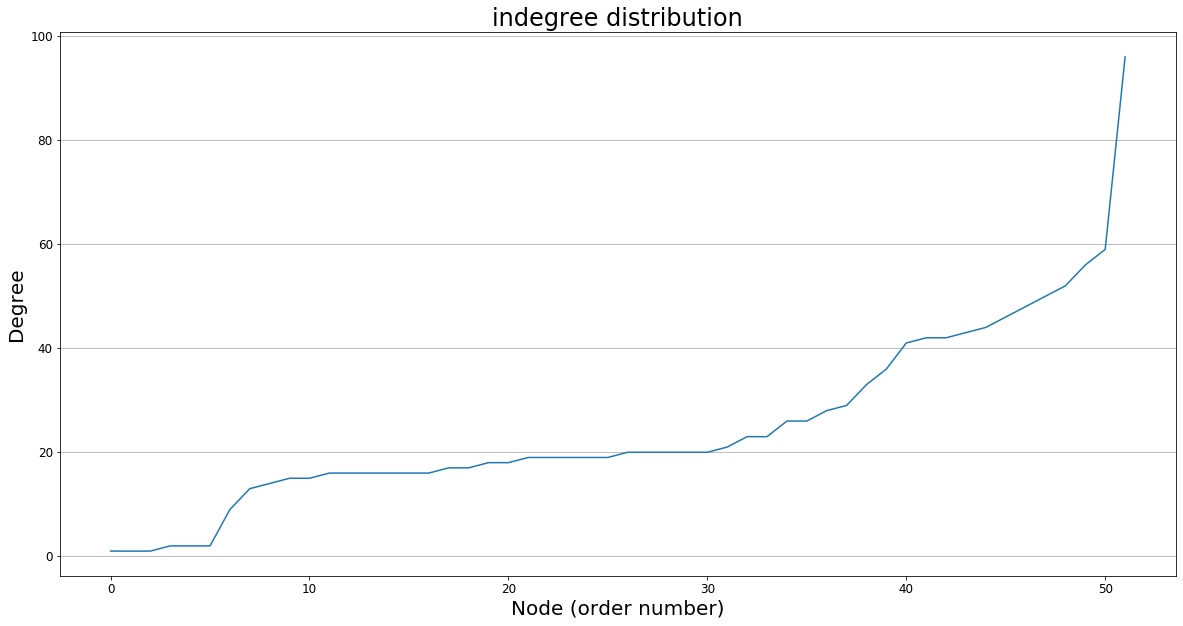

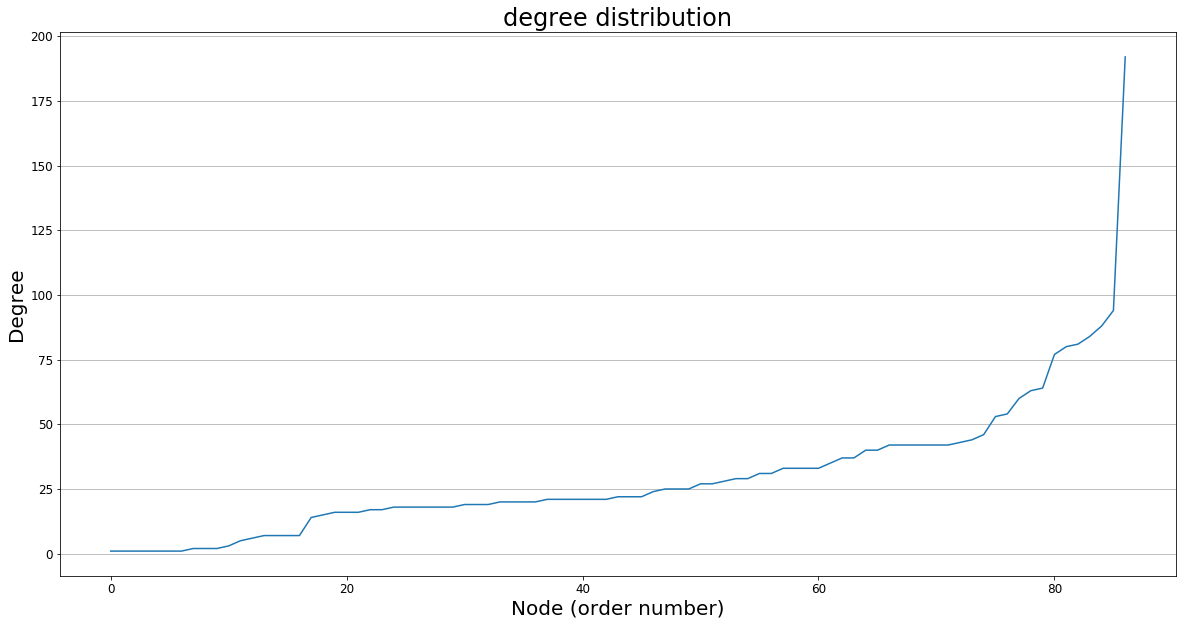

In [158]:
analyze_graph_from_collection(db.Q1Graph2)

2018-05-10 10:09:16
2026-01-01 00:00:00
Unique eType description counts
Financial (income, expenditure)                     519
Email                                               109
Phone                                                51
Travels-to                                           37
Buy                                                   6
Sell                                                  6
Author-of                                             1
Number of unique nodes (do not consider duplications) per node type description
Person                                          164,534
Product category                                  2,721
Document                                         33,622
Financial category                                   29
Country                                               6
Number of source nodes (do count duplications) per node type description
Person                                              204
Product category                               

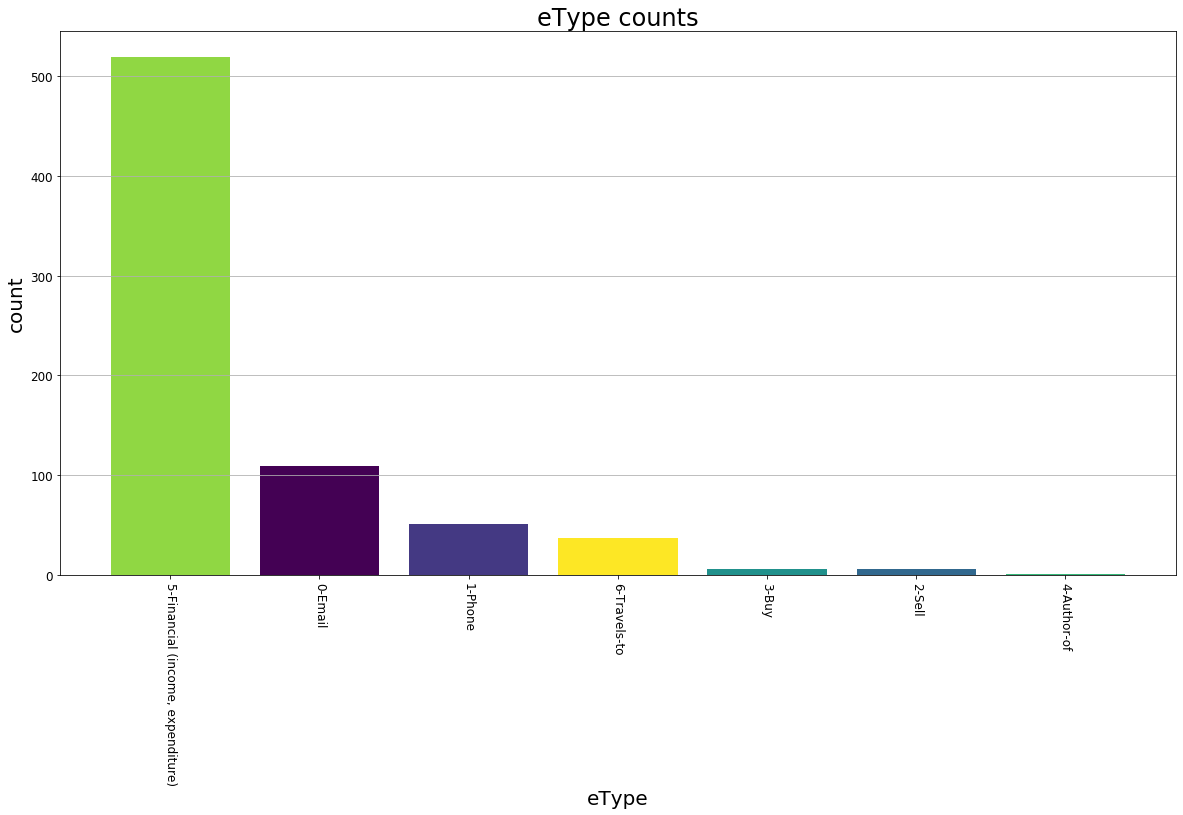

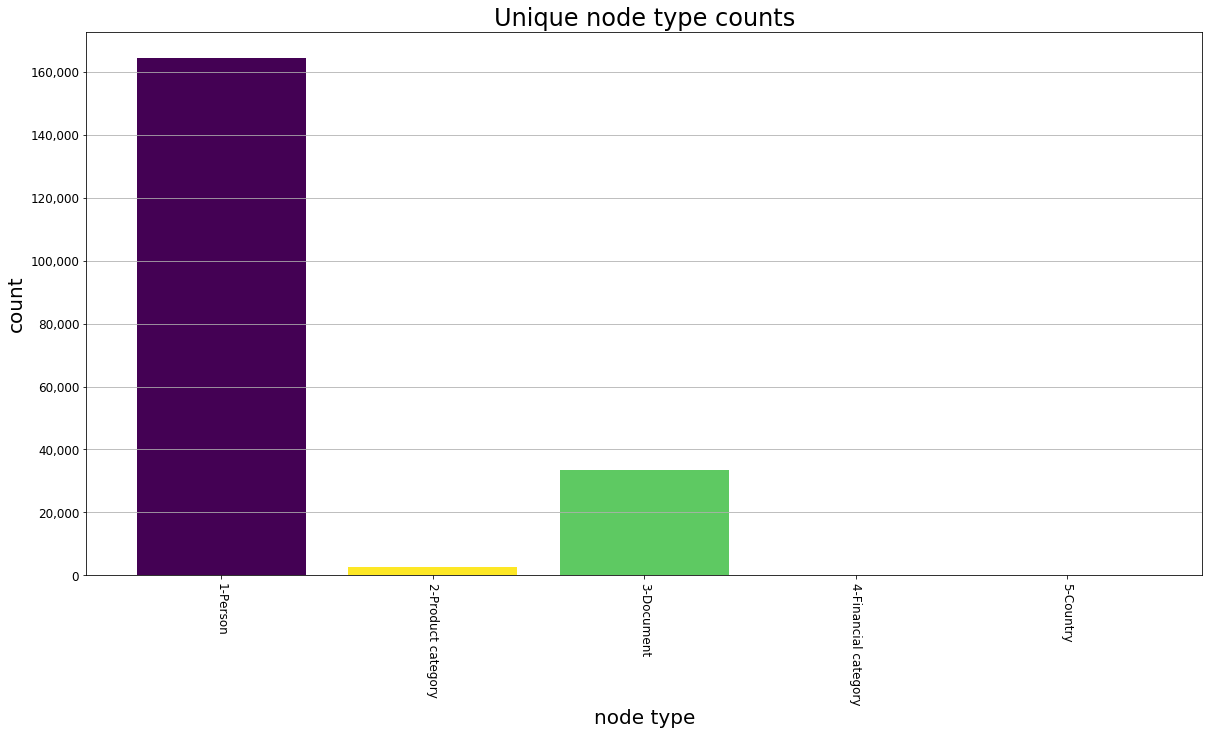

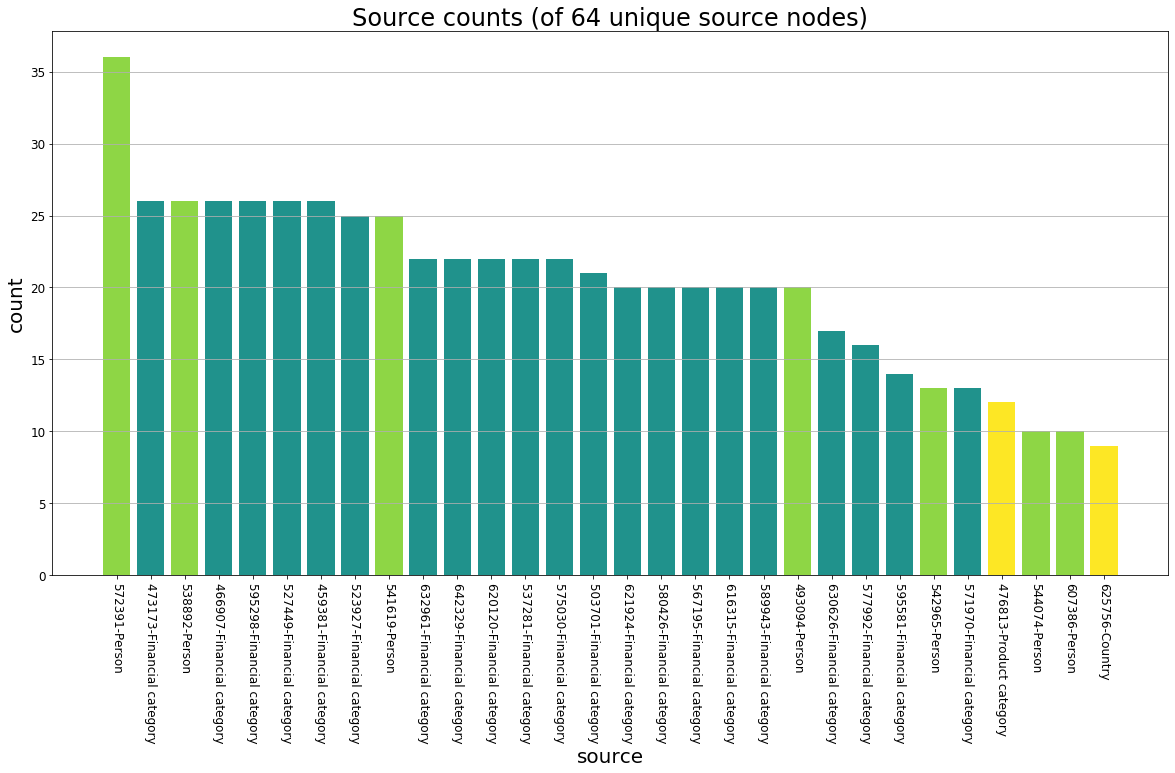

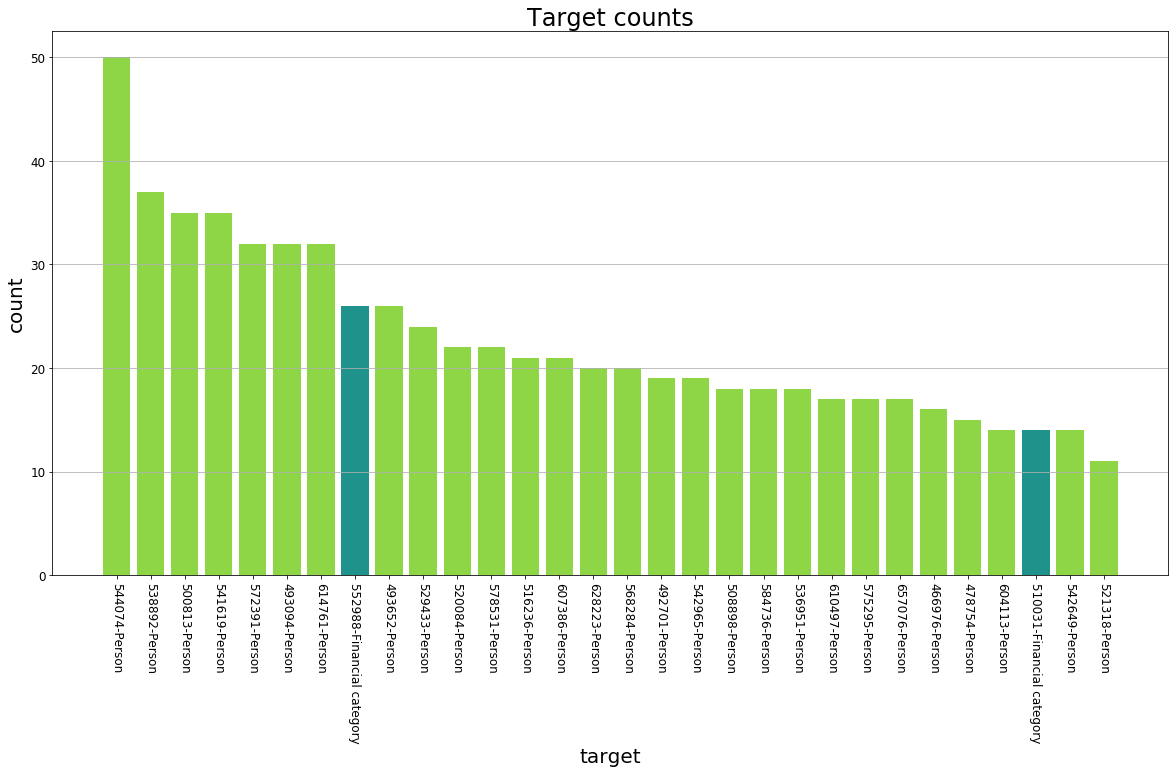

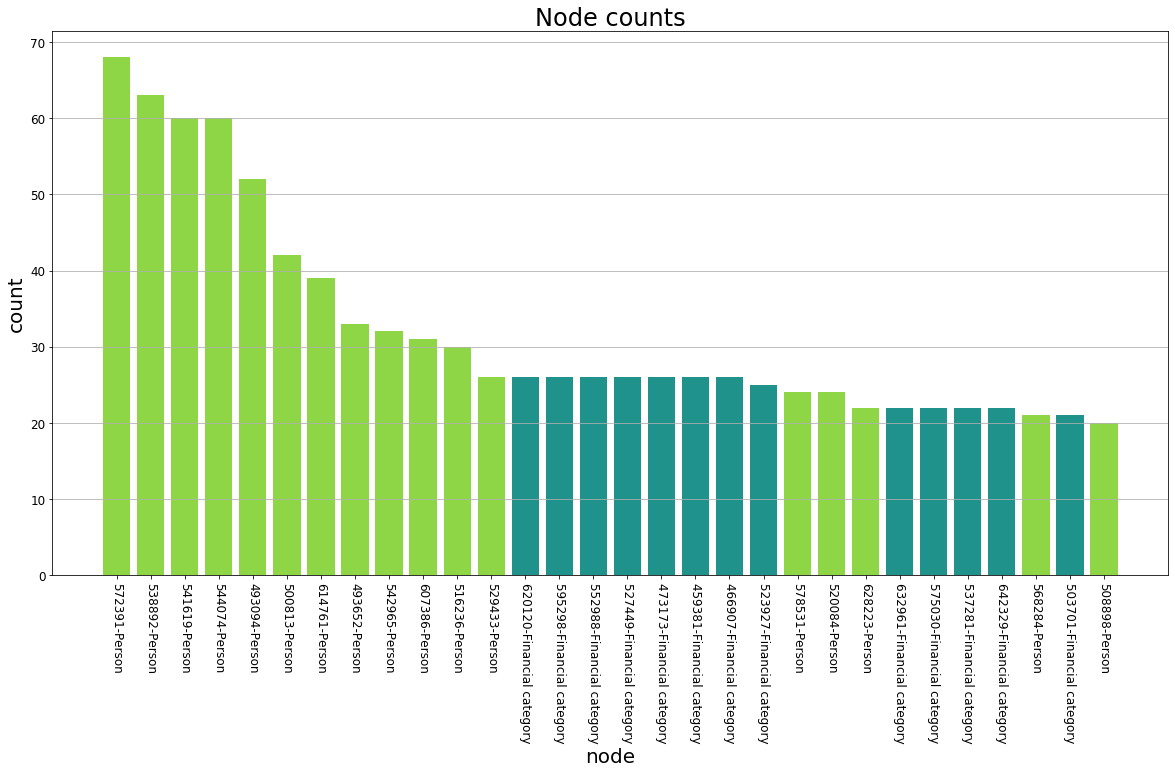

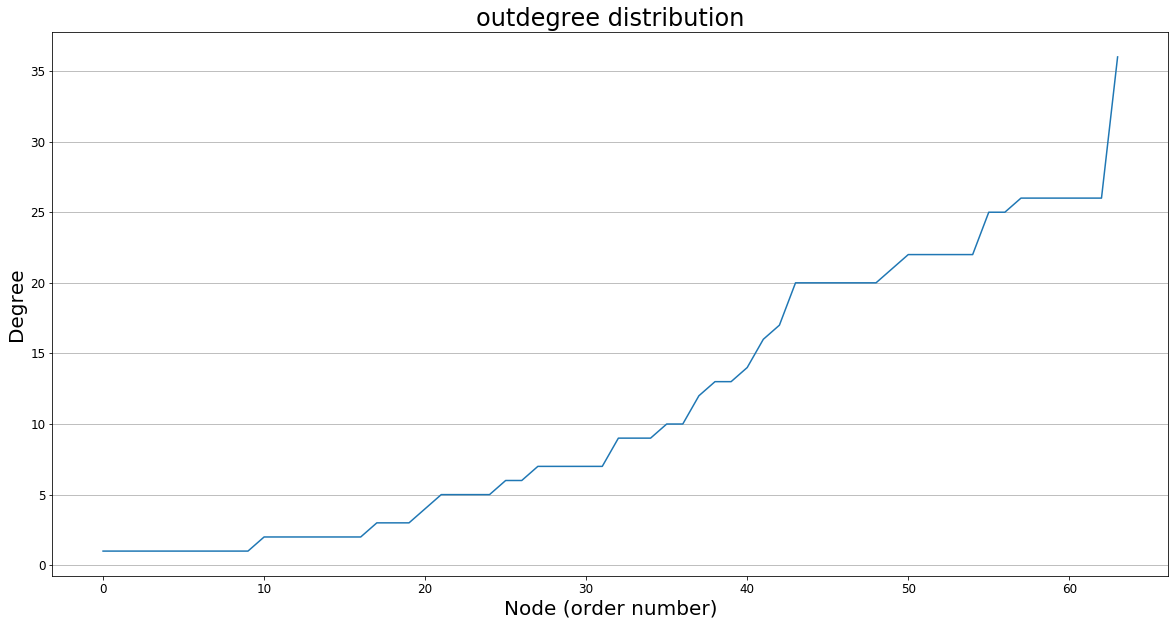

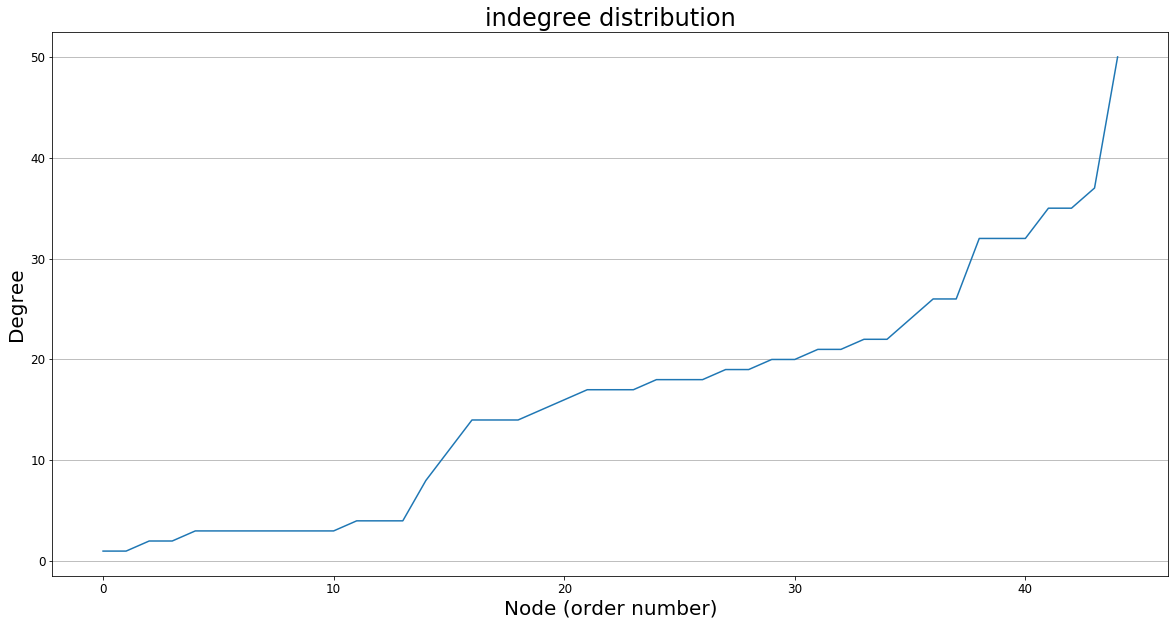

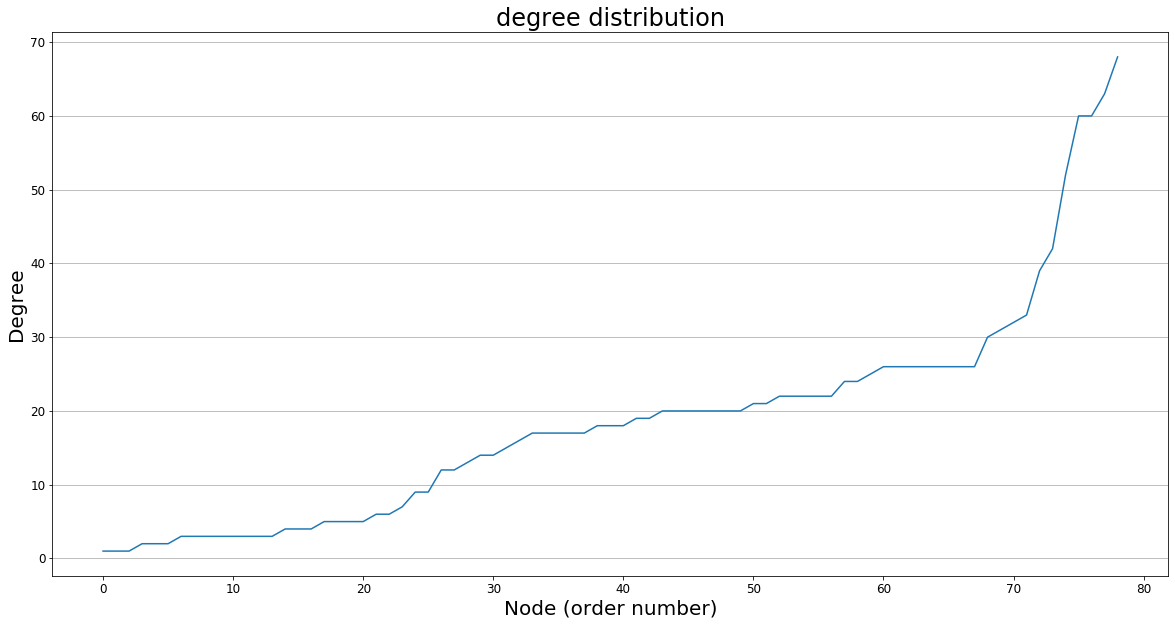

In [159]:
analyze_graph_from_collection(db.Q1Graph3)

2025-01-02 03:23:06
2026-01-01 00:00:00
Unique eType description counts
Financial (income, expenditure)                     494
Travels-to                                          115
Phone                                                61
Email                                                45
Buy                                                  12
Sell                                                  5
Number of unique nodes (do not consider duplications) per node type description
Person                                          164,534
Product category                                  2,721
Document                                         33,622
Financial category                                   29
Country                                               6
Number of source nodes (do count duplications) per node type description
Person                                              153
Product category                                     17
Document                                       

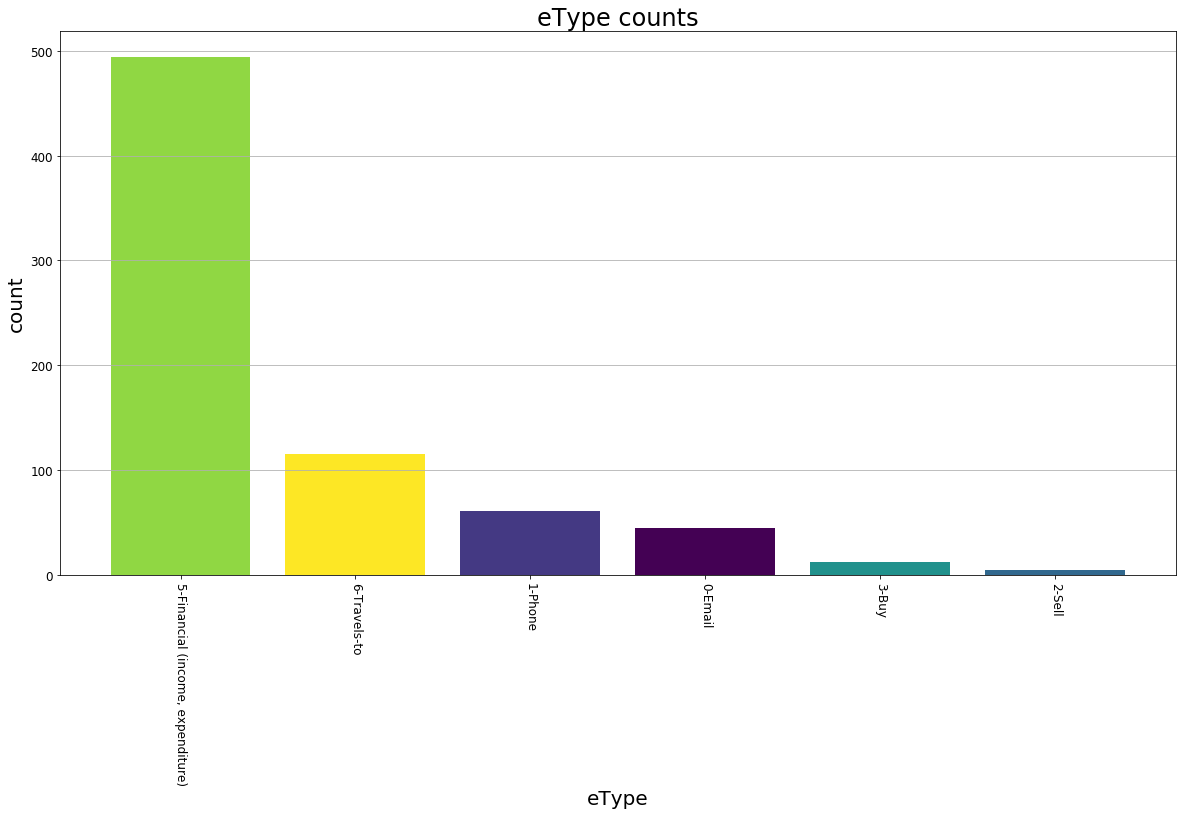

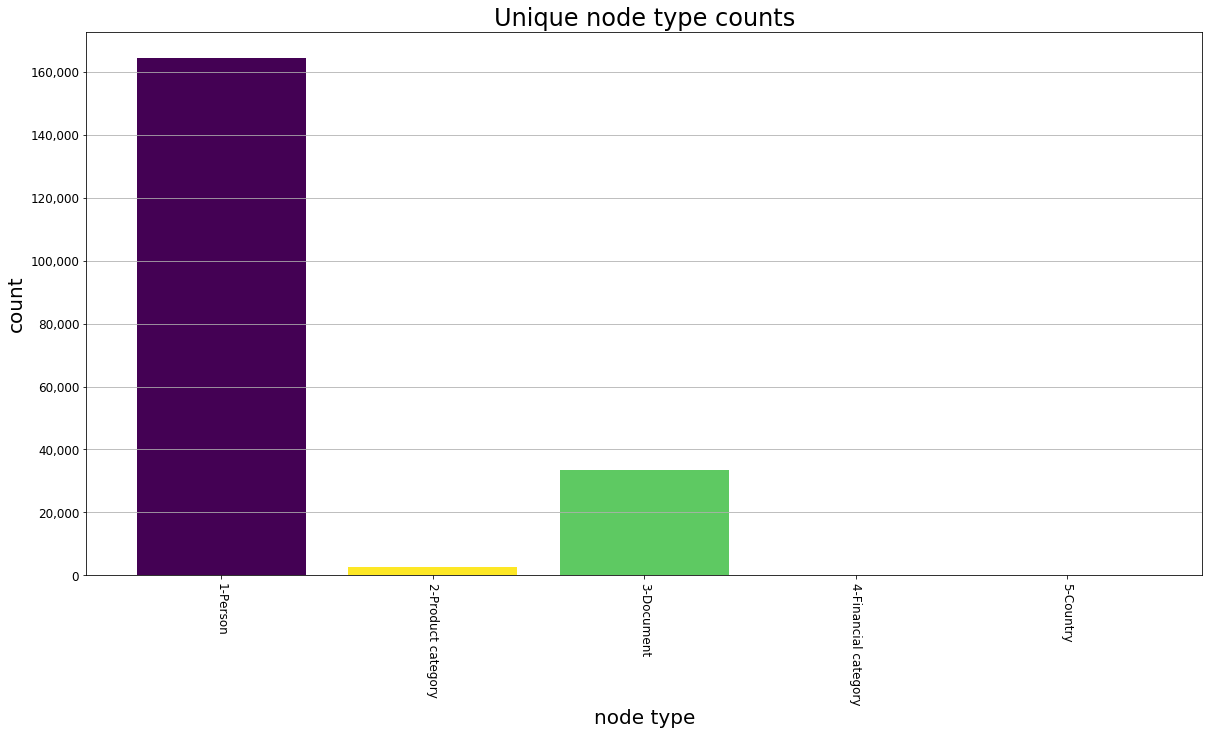

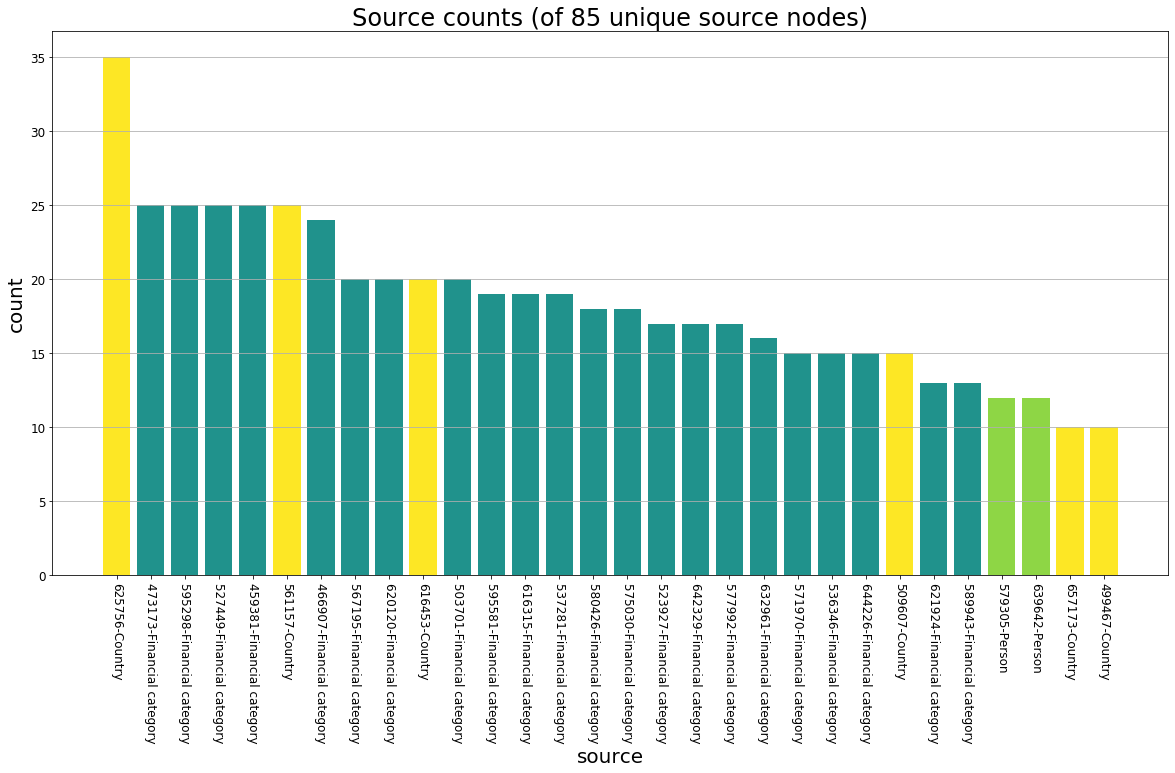

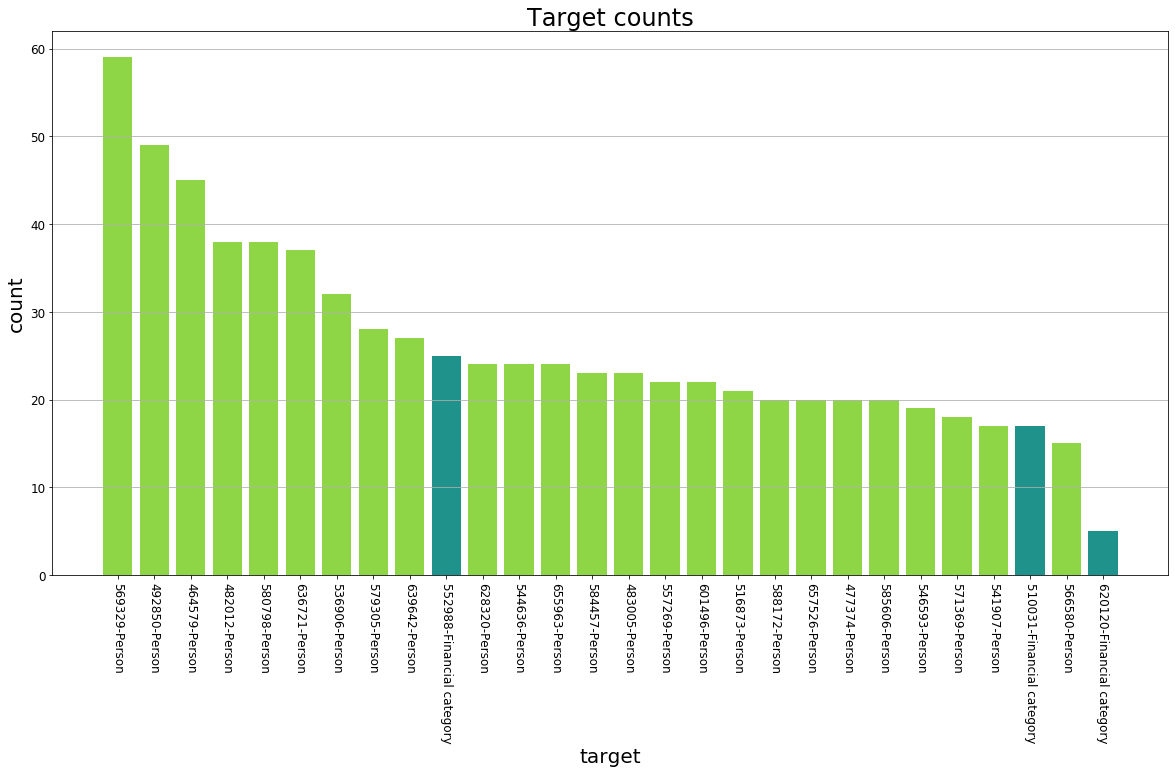

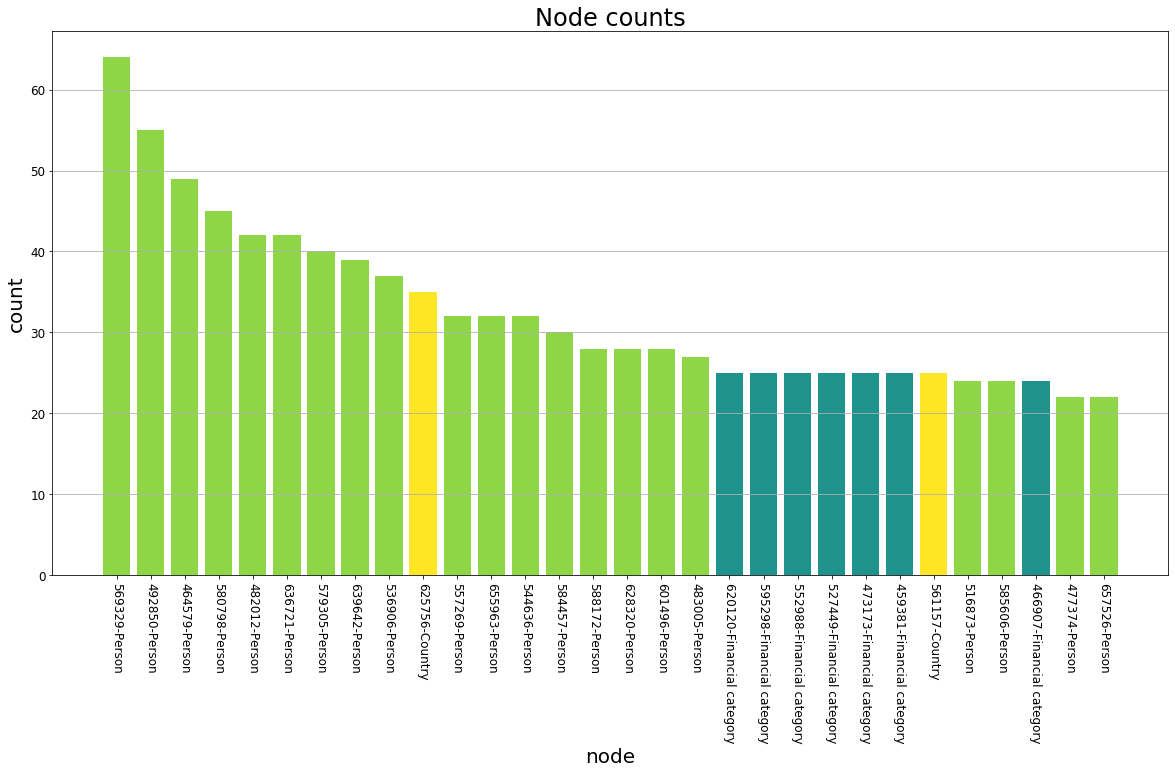

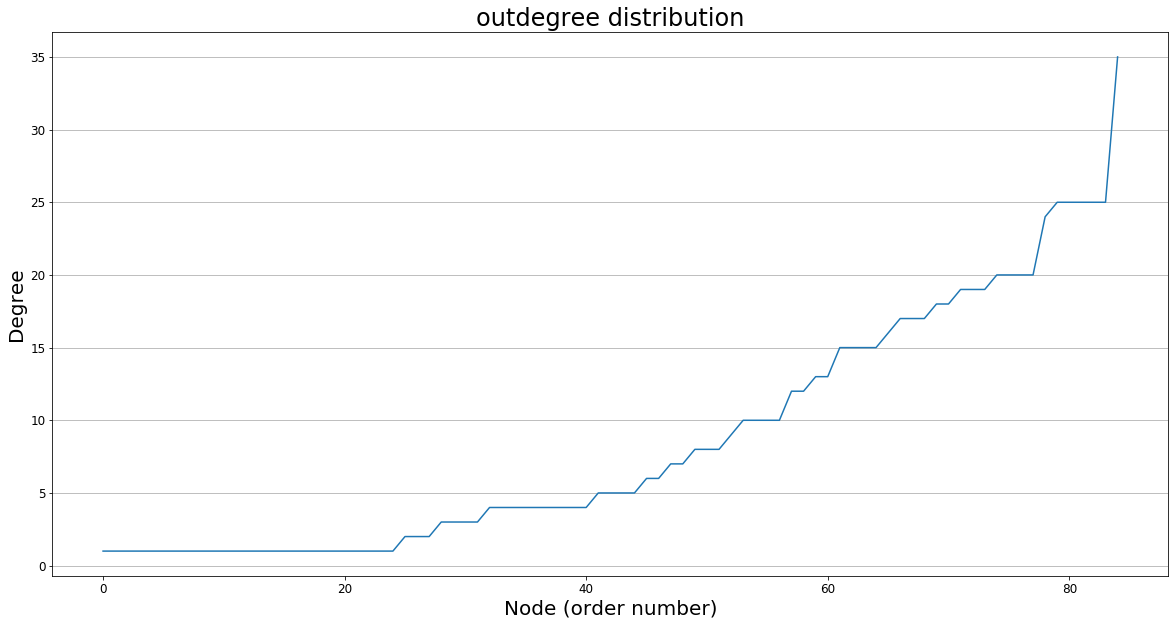

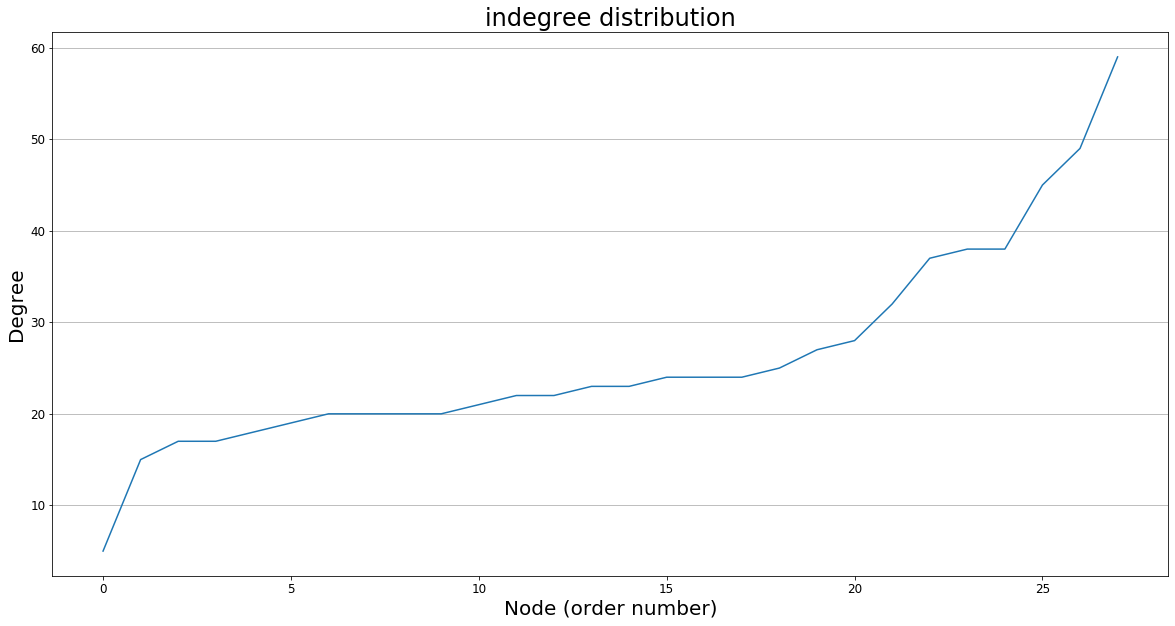

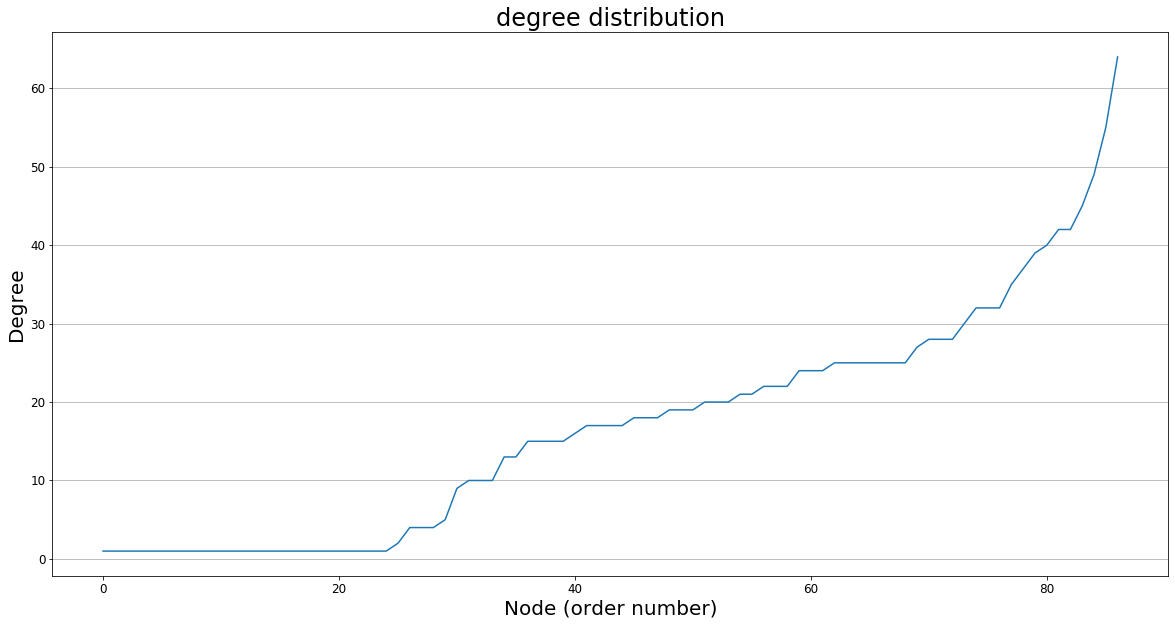

In [167]:
analyze_graph_from_collection(db.Q1Graph4)

2025-01-02 02:45:46
2026-01-01 00:00:00
Unique eType description counts
Financial (income, expenditure)                     203
Travels-to                                          110
Buy                                                  40
Email                                                17
Phone                                                14
Sell                                                 11
Number of unique nodes (do not consider duplications) per node type description
Person                                          164,534
Product category                                  2,721
Document                                         33,622
Financial category                                   29
Country                                               6
Number of source nodes (do count duplications) per node type description
Person                                               48
Product category                                     51
Document                                       

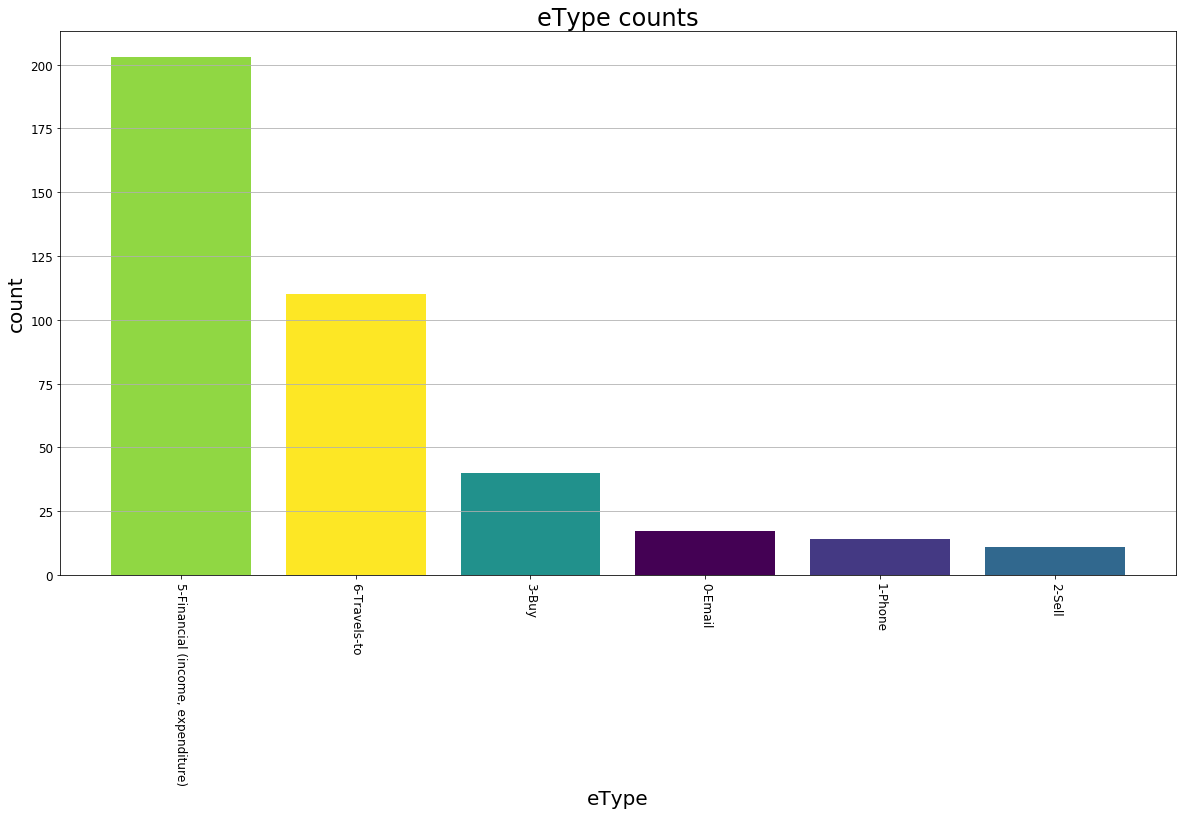

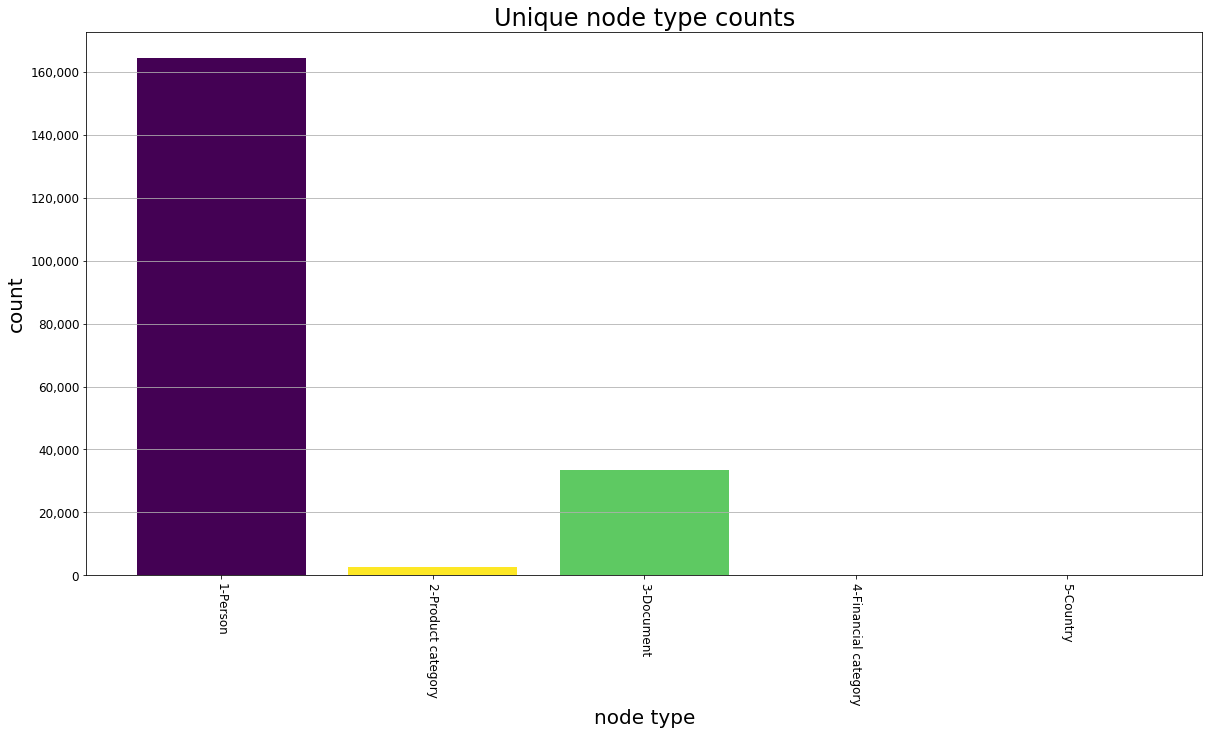

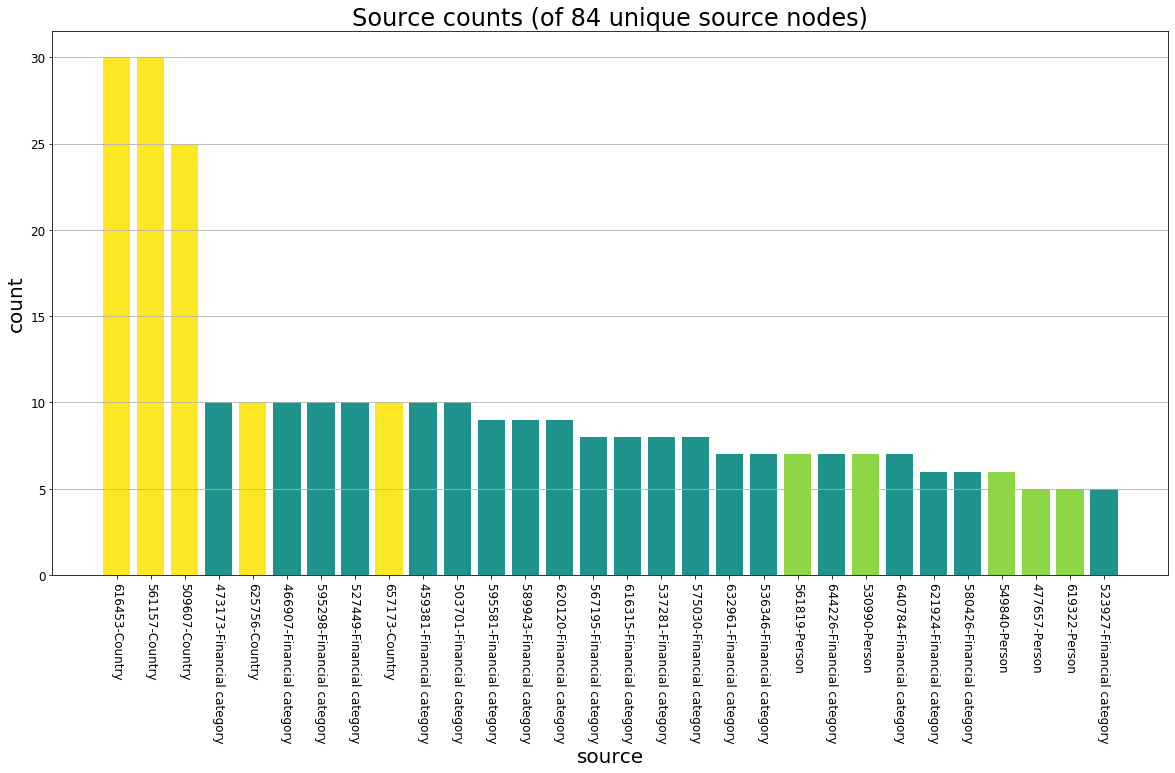

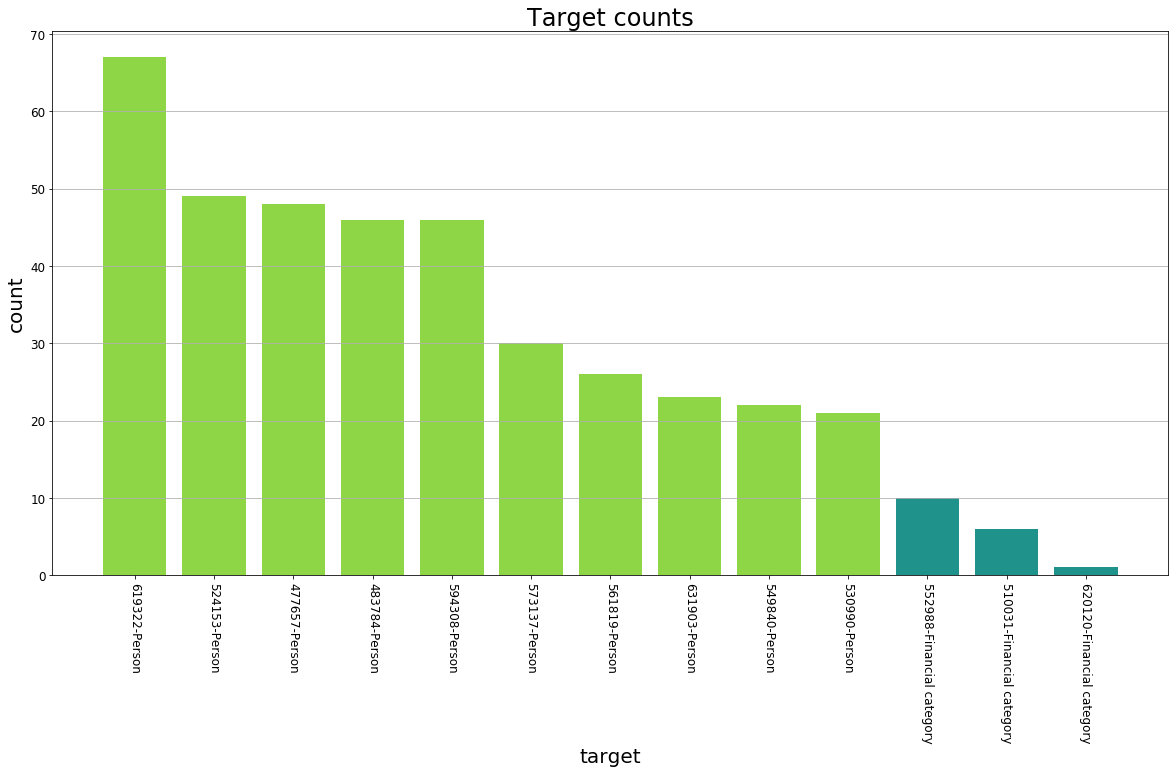

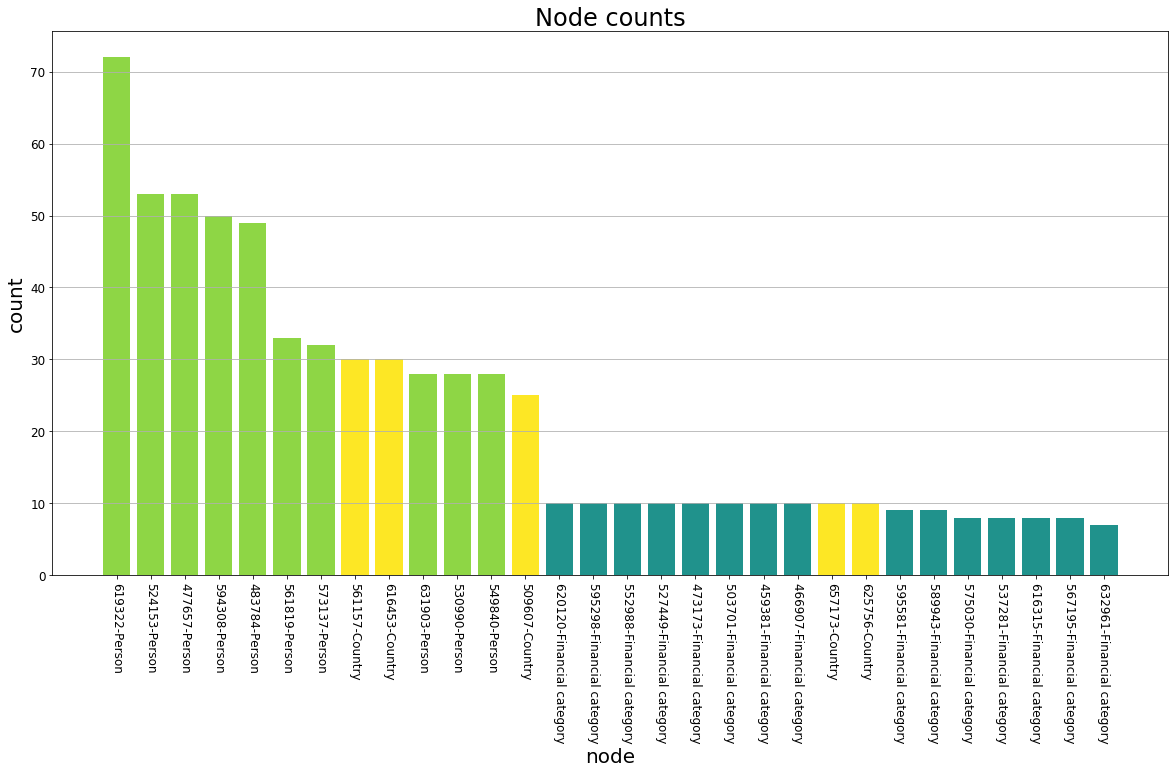

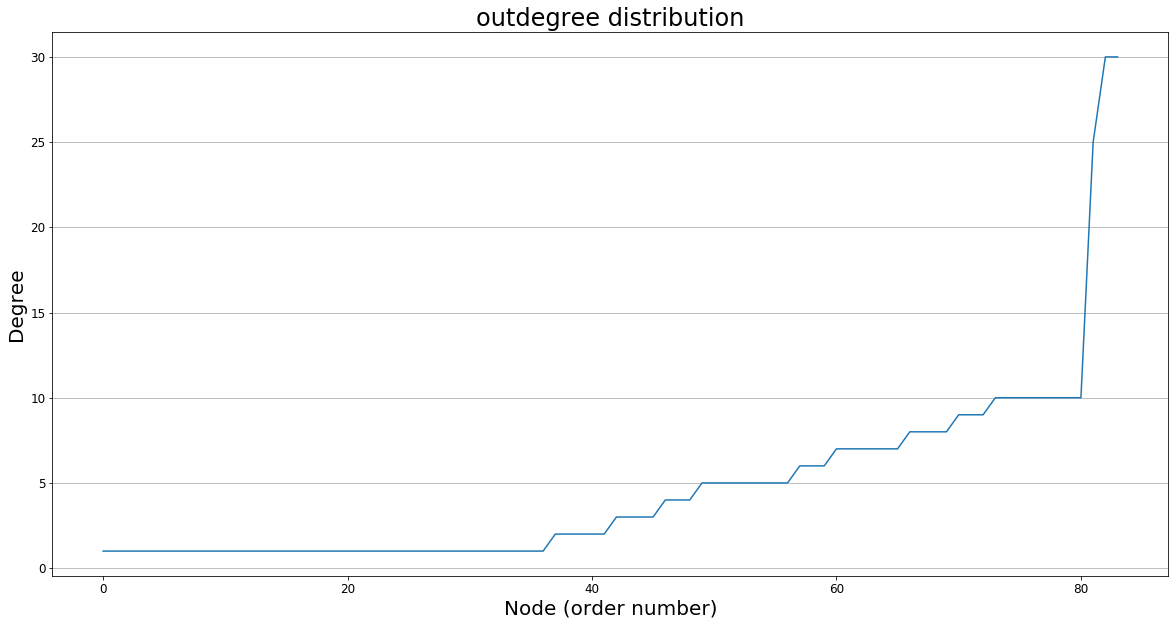

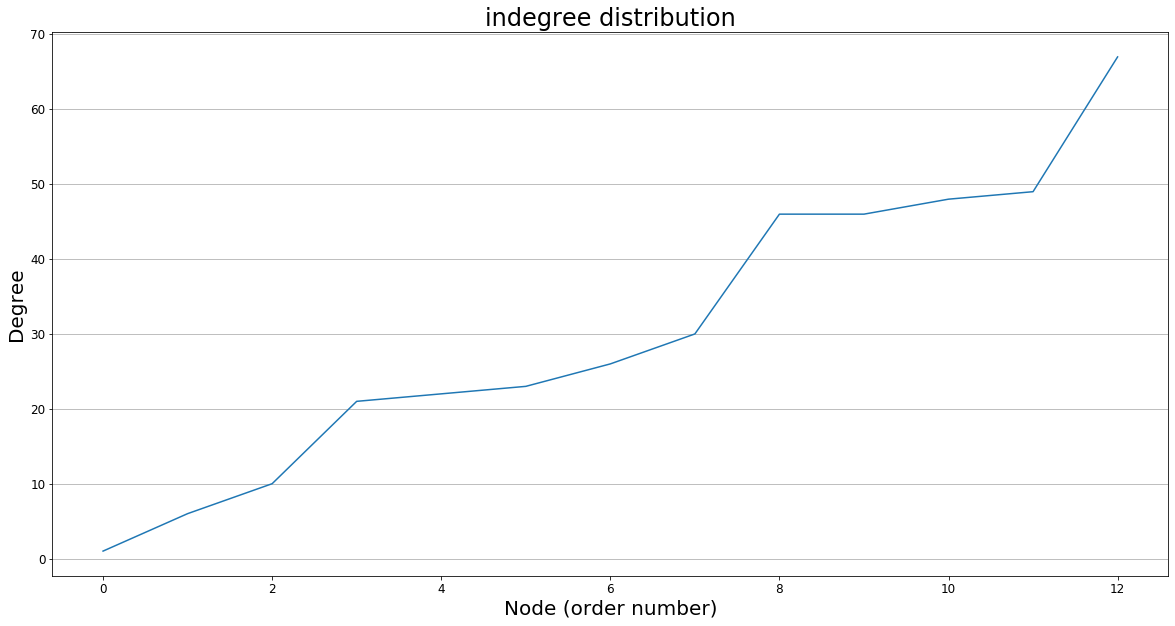

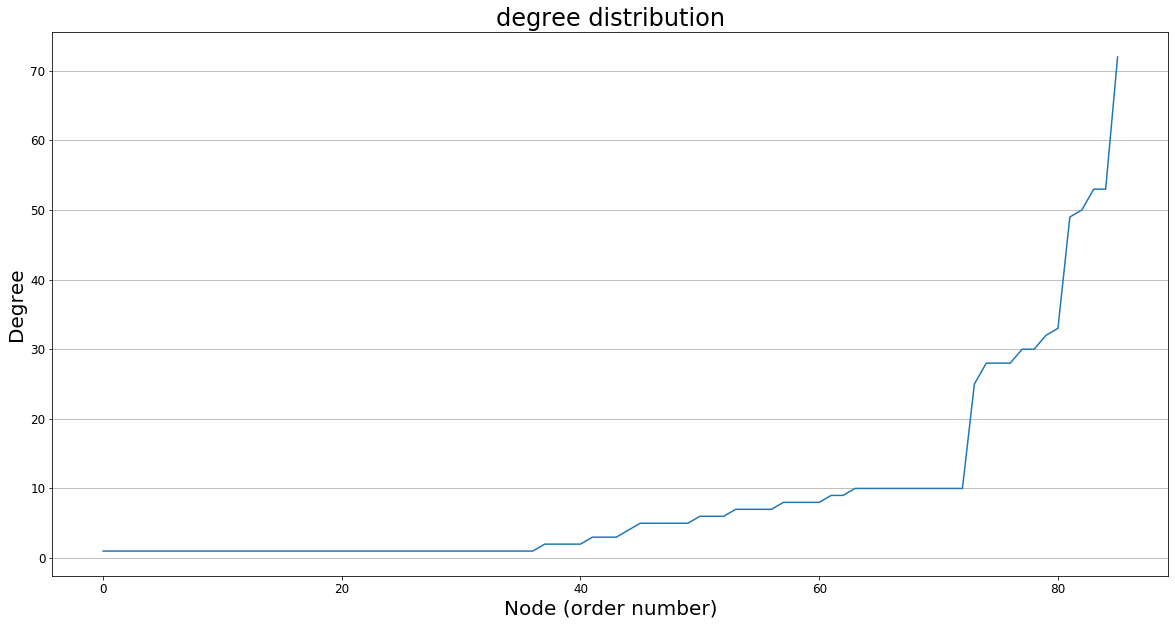

In [168]:
analyze_graph_from_collection(db.Q1Graph5)

In [22]:
import networkx as nx

In [289]:
list(eTypes.values())

['Email',
 'Phone',
 'Sell',
 'Buy',
 'Author-of',
 'Financial (income, expenditure)',
 'Travels-to']

/Users/vanpham/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/vanpham/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/vanpham/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


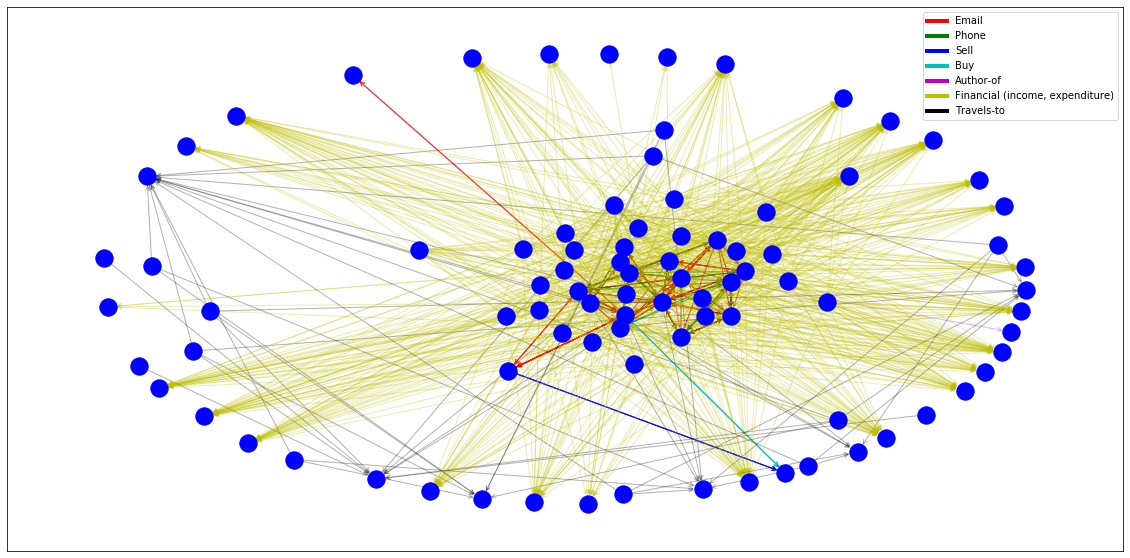

In [26]:
plot_graph(db.CGCSTemplate)

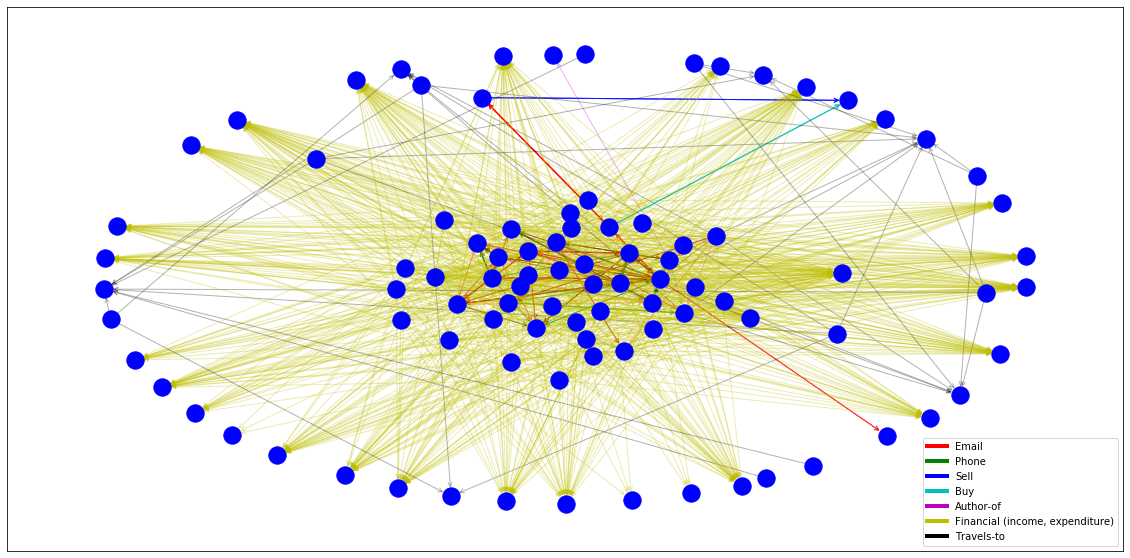

In [27]:
plot_graph(db.Q1Graph1)

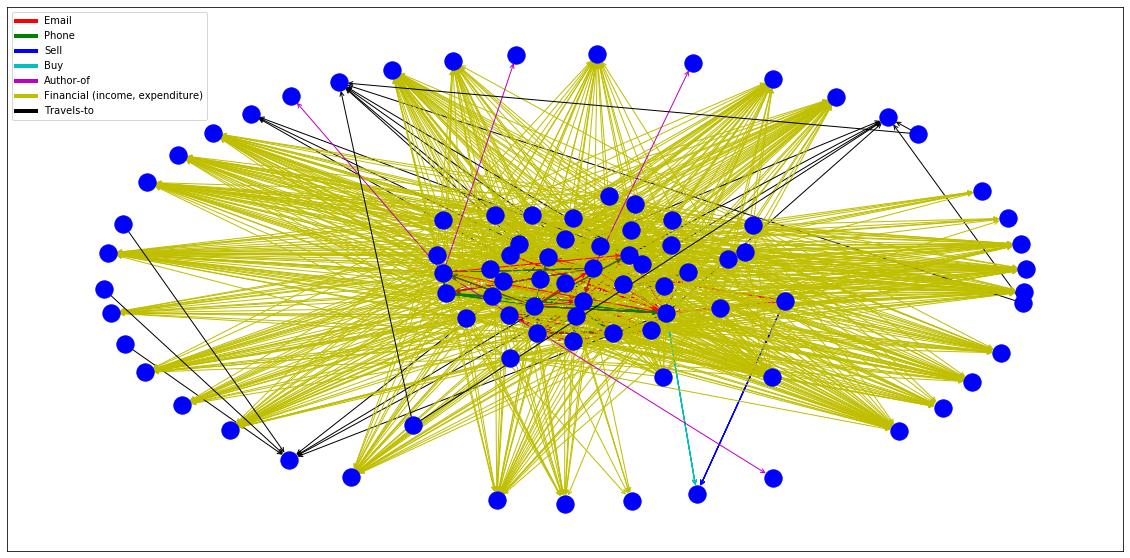

In [292]:
plot_graph(db.Q1Graph2)

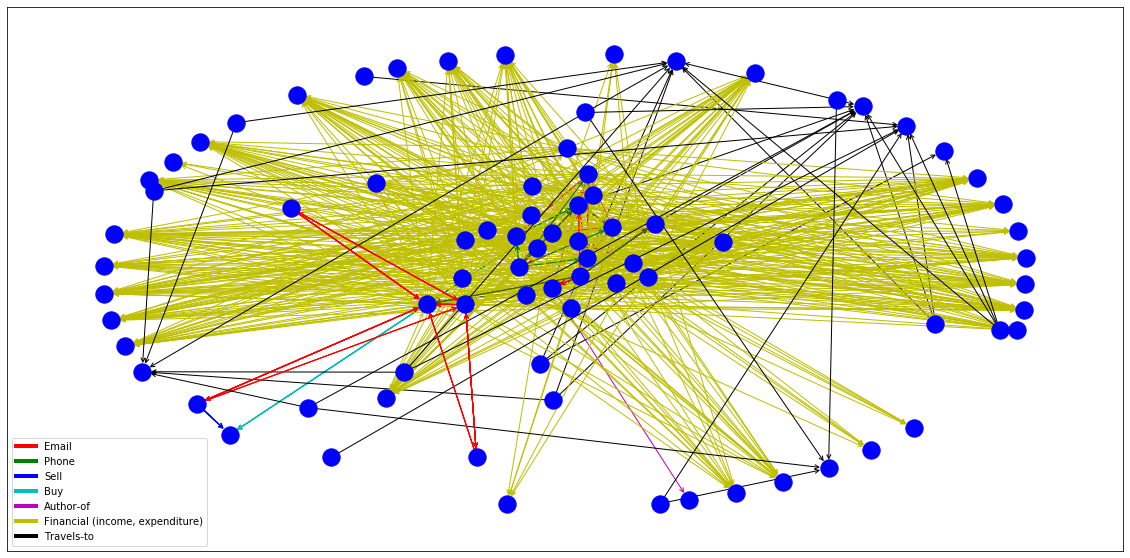

In [293]:
plot_graph(db.Q1Graph3)

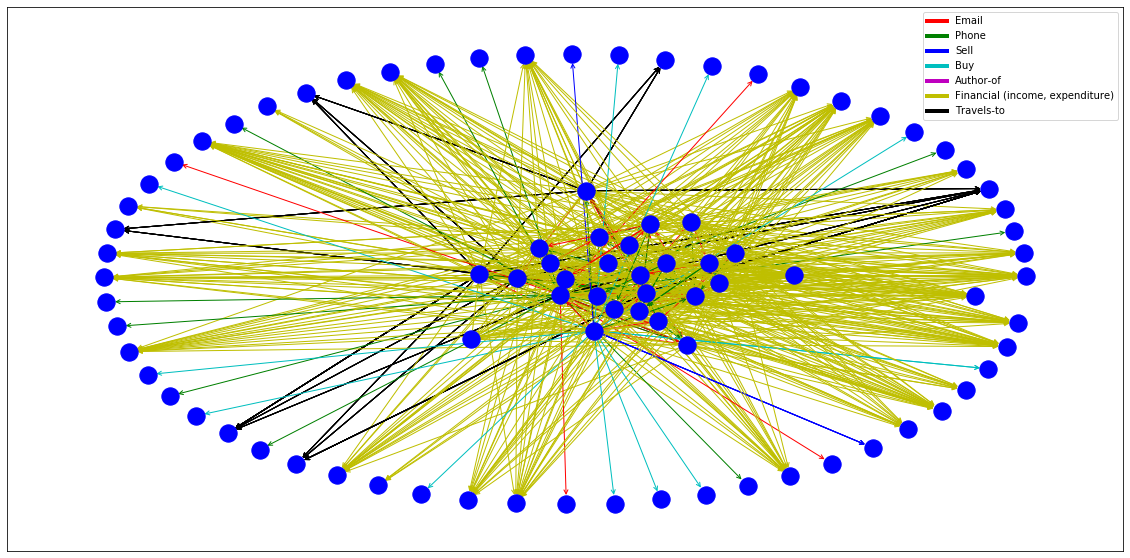

In [294]:
plot_graph(db.Q1Graph4)

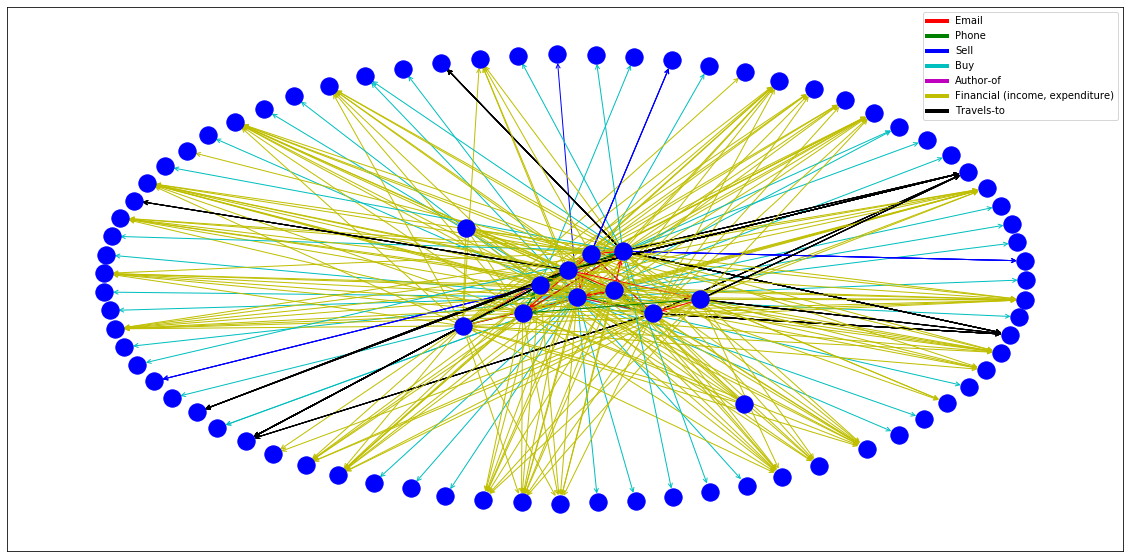

In [295]:
plot_graph(db.Q1Graph5)

In [284]:
db.list_collection_names()

['Q2Seed2',
 'DemographicCategories',
 'CGCSGraphData',
 'NodeTypeDescriptions',
 'Q2Seed1',
 'Q1Graph5',
 'Q1Graph1',
 'Q2Seed3',
 'Q1Graph3',
 'Q1Graph2',
 'CGCSGraphDataNodeTypes',
 'Q1Graph4']